### Mount Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/SMT202/Survey'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SMT202/Survey


### Load Relevant Libraries

In [0]:
!pip install wordcloud
!pip install fuzzywuzzy
import itertools

import pandas as pd
from datetime import datetime

import os
import re
import string
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.util import ngrams

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import operator
import time

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV,train_test_split,GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import export_graphviz
import six
import pydot
from sklearn import tree
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image

import pickle

import numpy as np

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Text Cleaning Functions

In [0]:
def get_date(created):
    '''
    This function is to convert timestamp from UNIX
    '''
    return datetime.datetime.fromtimestamp(created)

def lower_case(text):
    return text.lower()

def remove_stopwords(text):
    """ Remove Stopwords """
    stop_list = stopwords.words('english')
    stop_list += string.punctuation
    stop_list += ['thing','life','week','level','way','affect','well','time','problem','cause','issue','hour','singaporean'] #any other stop words
    return [word.strip() for word in text if word.strip() not in stop_list]

def remove_links(text):
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # remove bitly links
    text = re.sub(r'www\S+', '', text) # remove www links
    text = re.sub(r'.*\.com', '', text)
    return text

def remove_short_words(text,n):
    """ Remove words which are less than or equals to length of n """
    return [word for word in text if len(word) > n]

def remove_apostrophes(text):
    """ Remove words which have 's with a space """
    return [re.sub(r"'s", "",word) for word in text]

def remove_digits(text):
    """ Remove all numbers """
    whitelist = []
    return [re.sub(r'\d+','',word) for word in text if word not in whitelist]

""" Creates a dictionary with slangs and their equivalents and replaces them """
def replaceSlang(text):
    with open('slangs.txt',encoding="ISO-8859-1") as file:
        slang_map = dict(map(str.strip, line.partition('\t')[::2]) for line in file if line.strip())
    return [slang_map[word] if word in slang_map.keys() else word for word in text]

""" Creates a dictionary with contractions and their equivalents and replaces them """
def replaceContraction(text):
    with open('contractions.txt',encoding="ISO-8859-1") as file:
        contraction_map = dict(map(str.strip, line.partition('\t')[::2]) for line in file if line.strip())
    return [contraction_map[word] if word in contraction_map.keys() else word for word in text]

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def remove_multispaces(text):
    """ Replace multiple spaces with only 1 space """
    return [re.sub(r' +', " ",word) for word in text]

def keep_alphanum(text):
    """ Keep Alphanumeric characters """
    return [word for word in text if word.isalnum()]

def remove_duplicates_in_sentence(text):
    """ Remove consecutive words in a sentence"""
    return re.sub(r'\b(\w+)( \1\b)+', r'\1', text)

def normalize_word(text):
    """ Own mapping function """
    replacement_dict = {'e.g':'example','someone':'people','thing':'object','something':'object','cant':'cannot','stresssed':'stressed','mentallly':'mentally',"/":'or',
                        'xiao':'little','dont':"do not","ex":"expensive"}

    text = [replacement_dict[word.strip()] if word.strip() in replacement_dict.keys() else word.strip() for word in text]

    return text

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_words(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    # Pos tagging
    nltk_tagged = nltk.pos_tag(text)  

    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
        
    # lemmatizing 
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is not None:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))

    return (lemmatized_sentence)

def clean_text(texts):
    new_texts = [lower_case(str(text)) for text in texts]
    new_texts = [remove_links(text) for text in new_texts]
    new_texts = [removeEmoticons(text) for text in new_texts]
    new_texts = [nltk.word_tokenize(str(text)) for text in new_texts]
    new_texts = [replaceSlang(text) for text in new_texts]
    new_texts = [replaceContraction(text) for text in new_texts]
    new_texts = [normalize_word((text)) for text in new_texts]
    new_texts = [remove_apostrophes((text)) for text in new_texts]
    new_texts = [keep_alphanum(text) for text in new_texts]
    new_texts = [lemmatize_words(text) for text in new_texts]
    new_texts = [remove_multispaces(text) for text in new_texts]
    new_texts = [remove_short_words(text,2) for text in new_texts]
    new_texts = [normalize_word((text)) for text in new_texts]
    new_texts = [remove_stopwords(text) for text in new_texts]
    new_texts = [' '.join(text) for text in new_texts]
    new_texts = [remove_duplicates_in_sentence(str(text)) for text in new_texts]
    
    return new_texts

### EDA Functions

In [0]:
def eda_symbols(texts):
    ans = []
    for text in texts:
        text = str(text).lower().strip()
        text = nltk.word_tokenize(text)
        for word in text:
            if re.findall('\W\S',word) != []:
                ans.append(word)

    word_cloud_dict=Counter(ans)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

def eda_digits(texts):
    ans = []
    for text in texts:
        text = str(text).lower().strip()
        text = nltk.word_tokenize(text)
        for word in text:
            if re.findall(r'\d+',word) != []:
                ans.append(word)

    word_cloud_dict=Counter(ans)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

def eda_consecutive(texts):
    ans = []
    for text in texts:
        text = str(text).lower().strip()
        text = nltk.word_tokenize(text)
        for word in text:
            if re.findall(r'([a-z])\1\1+',word) != []:
                ans.append(word)

    word_cloud_dict=Counter(ans)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

def eda_words_length_2(texts):
    ans = []
    for text in texts:
        text = str(text).lower().strip()
        text = nltk.word_tokenize(text)
        for word in text:
            if len(word) == 2 and word.isalpha():
                ans.append(word)

    word_cloud_dict=Counter(ans)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

def eda_words_length_1(texts):
    ans = []
    for text in texts:
        text = str(text).lower().strip()
        text = nltk.word_tokenize(text)
        for word in text:
            if len(word) == 1 and word.isalpha():
                ans.append(word)

    word_cloud_dict=Counter(ans)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### Text Pre-Processing

#### Load Dataset

In [0]:
survey_df = pd.read_csv('Mental Wellness Survey.csv')
survey_df['merge_companion_reason'] = survey_df['perfect_companion'] + '. ' + survey_df['perfect_companion_reason']
survey_df.drop(['perfect_companion_reason'],inplace=True,axis=1)
survey_df

cleaning_df = survey_df[['first_word','second_word','third_word','importance_mental_wellness_reason', 
                         'mental_wellness_causes', 'activity_mental_wellness', 'limitation_reason', 'first_task_when_stress', 
                         'alternative_task_stress', 'importance_talking_someone_reason','merge_companion_reason','counselling_help_reason']]


#### EDA

##### Looking at symbols

first_word


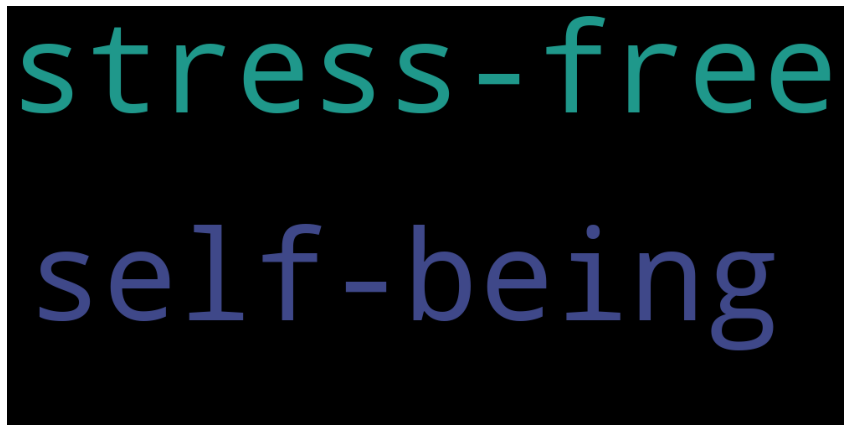

second_word


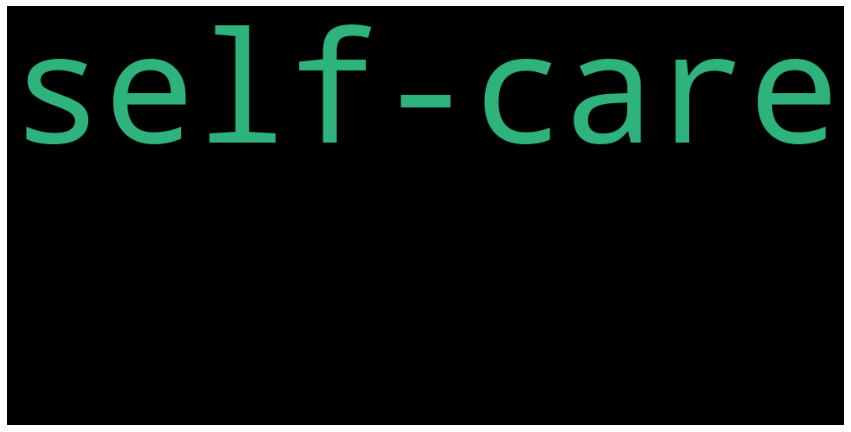

third_word


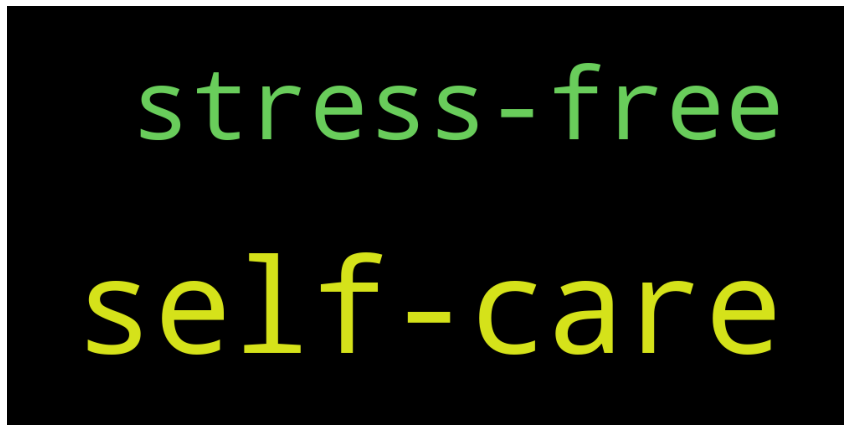

importance_mental_wellness_reason


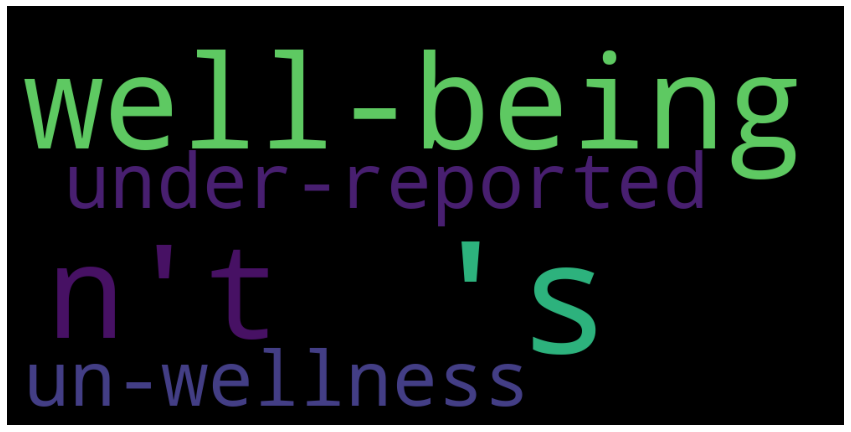

mental_wellness_causes


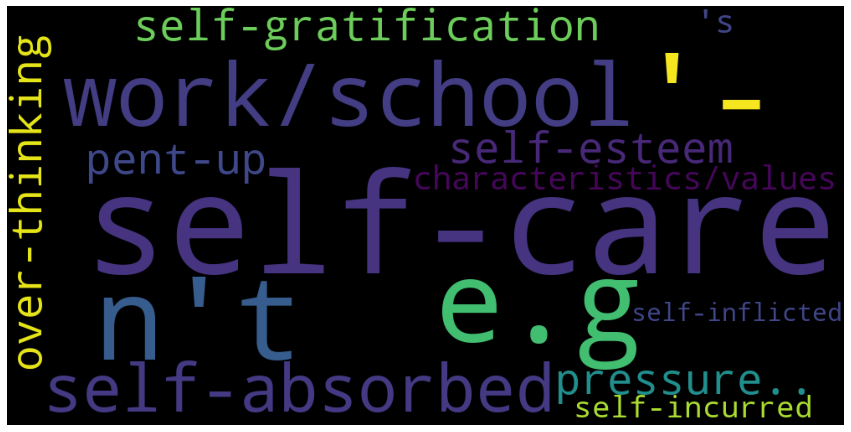

activity_mental_wellness


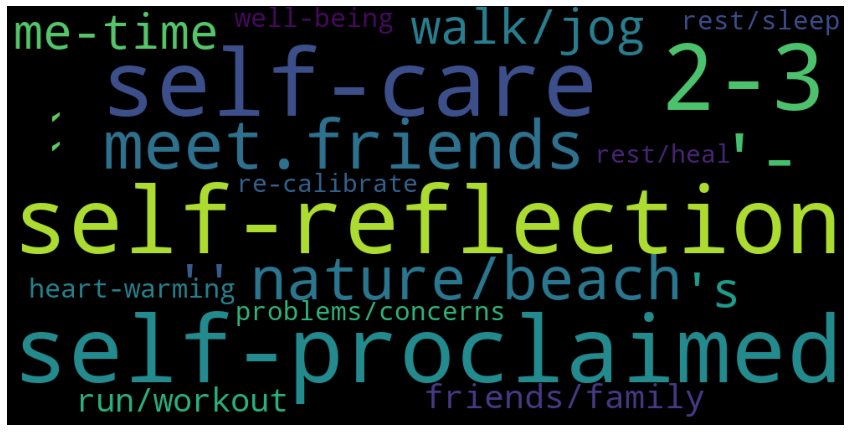

limitation_reason


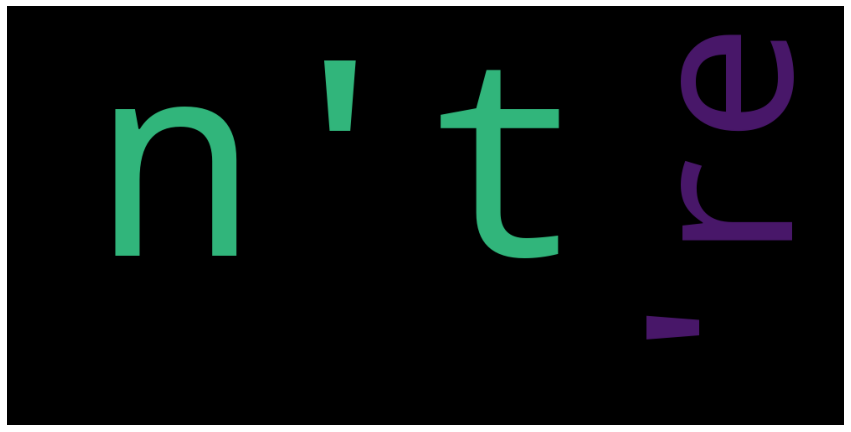

first_task_when_stress


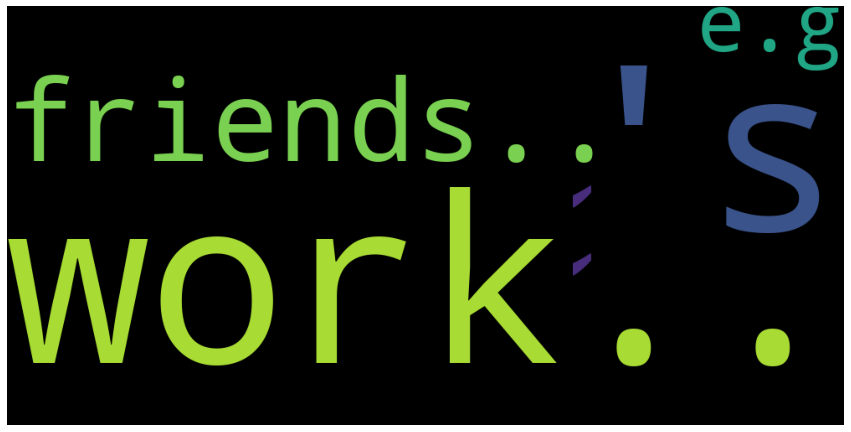

alternative_task_stress


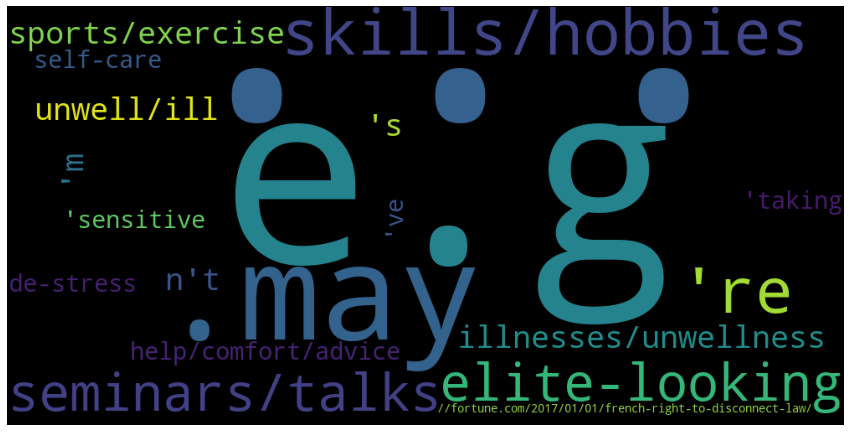

importance_talking_someone_reason


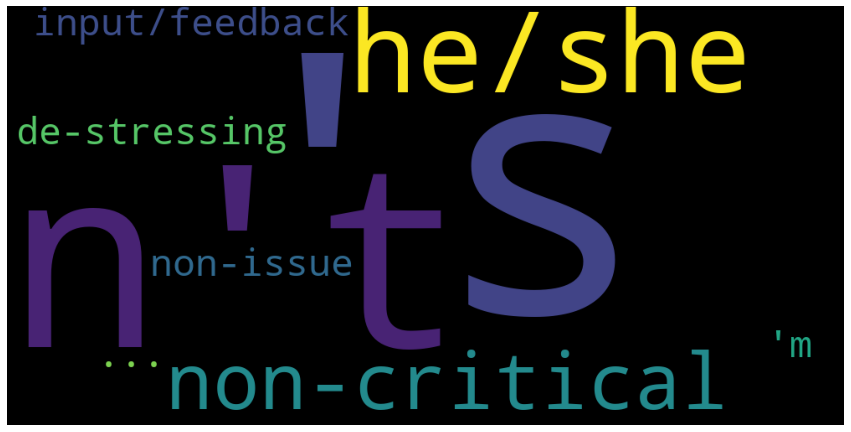

merge_companion_reason


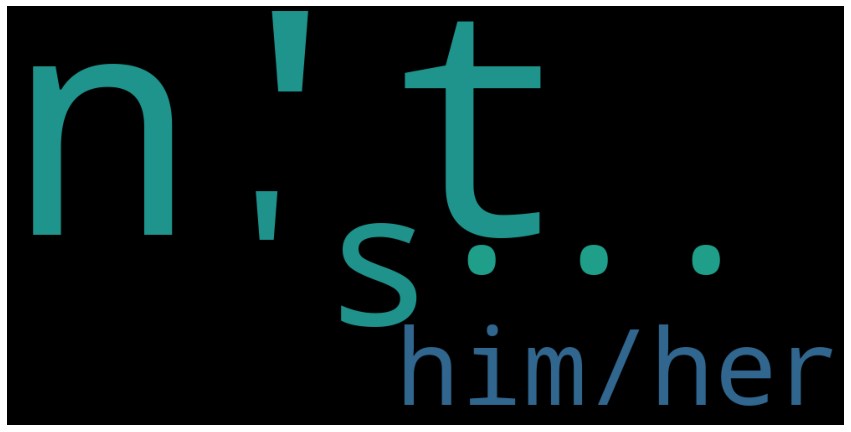

counselling_help_reason


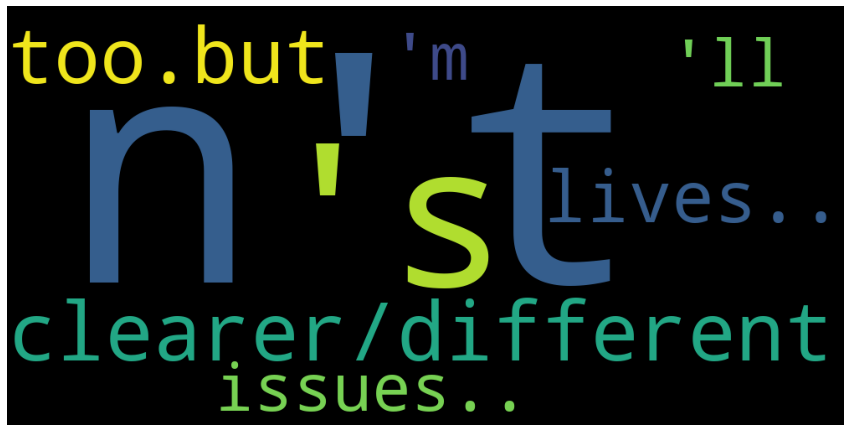

In [0]:
for column in cleaning_df:
    print(column)
    try:
        eda_symbols(list(cleaning_df[column]))
    except:
        continue

##### Looking at digits

first_word
second_word
third_word
importance_mental_wellness_reason


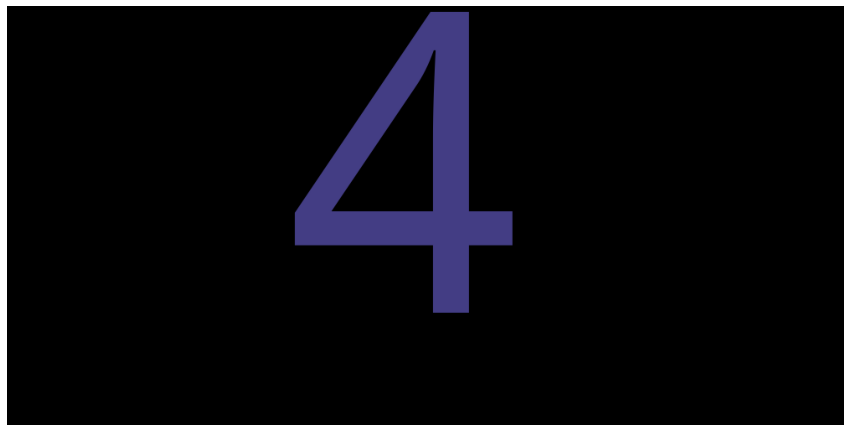

mental_wellness_causes


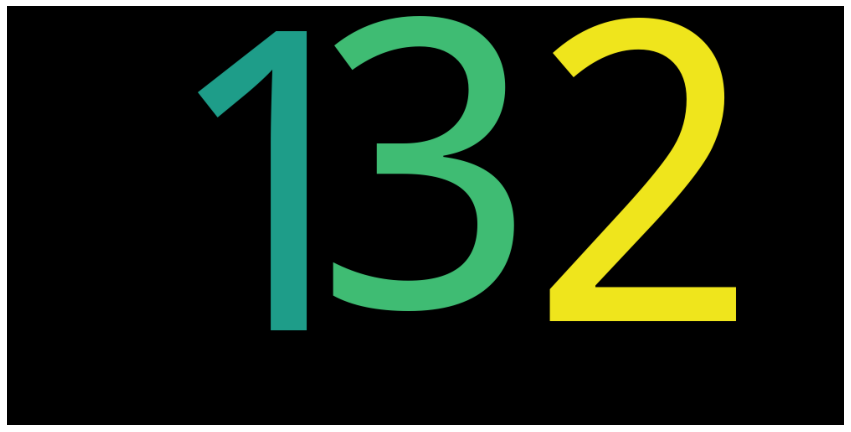

activity_mental_wellness


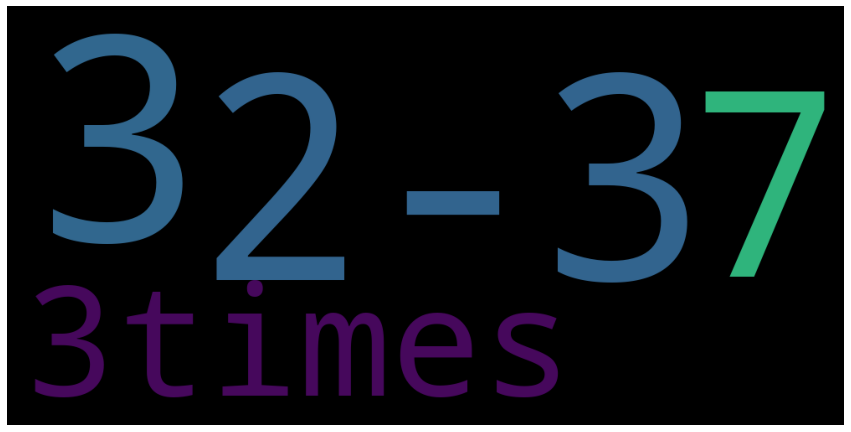

limitation_reason


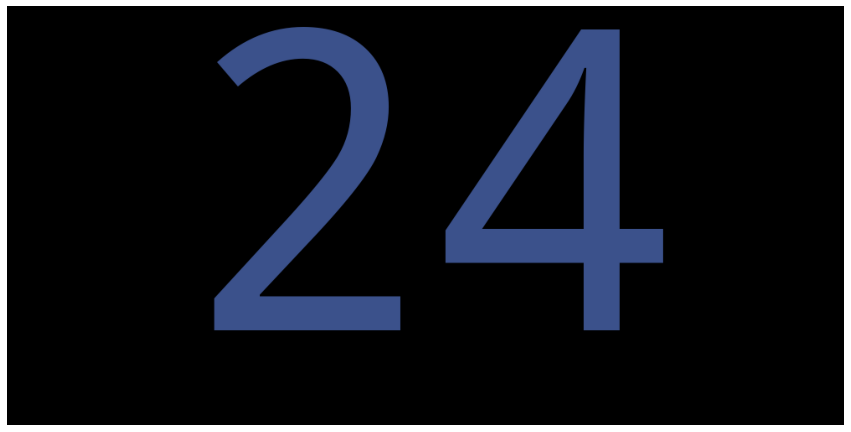

first_task_when_stress
alternative_task_stress


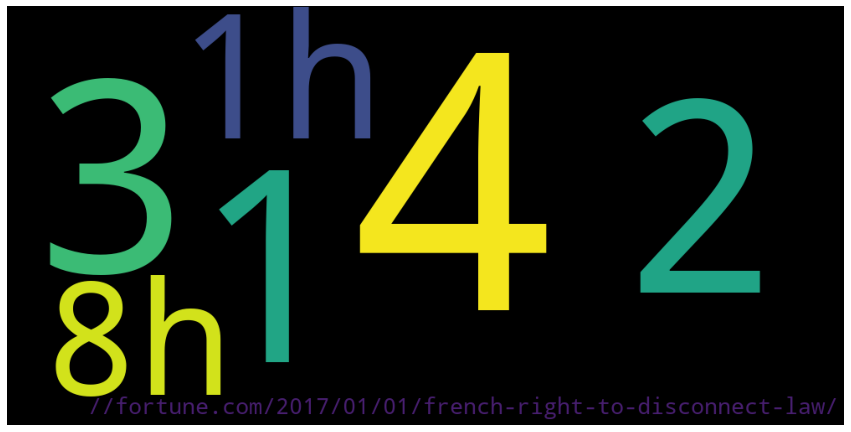

importance_talking_someone_reason


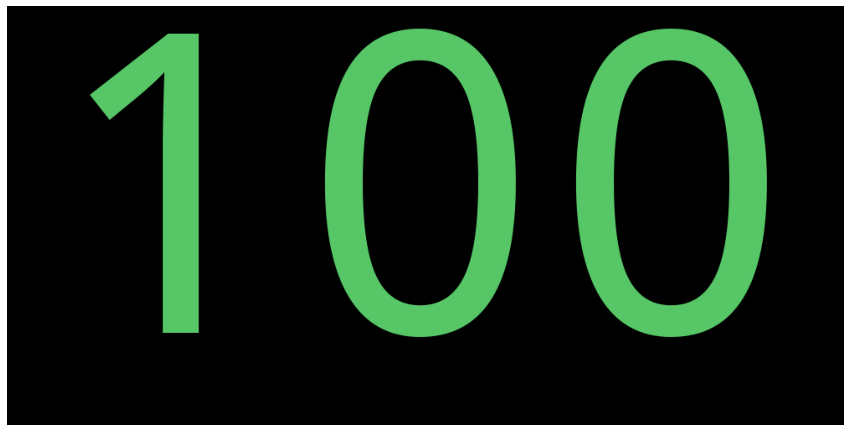

merge_companion_reason


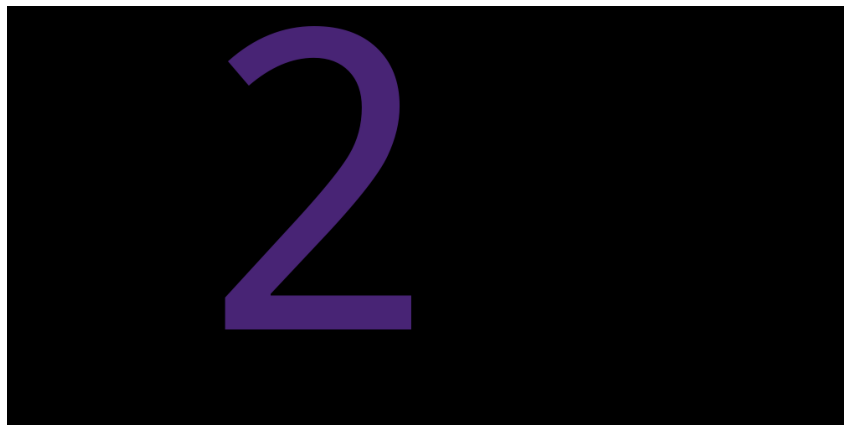

counselling_help_reason


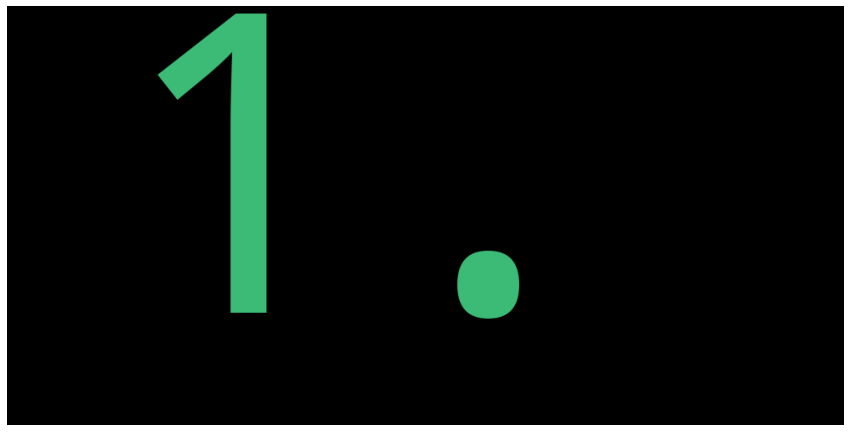

In [0]:
for column in cleaning_df:
    print(column)
    try:
        eda_digits(list(cleaning_df[column]))
    except:
        continue

##### Looks with consecutive characters

first_word
second_word
third_word
importance_mental_wellness_reason


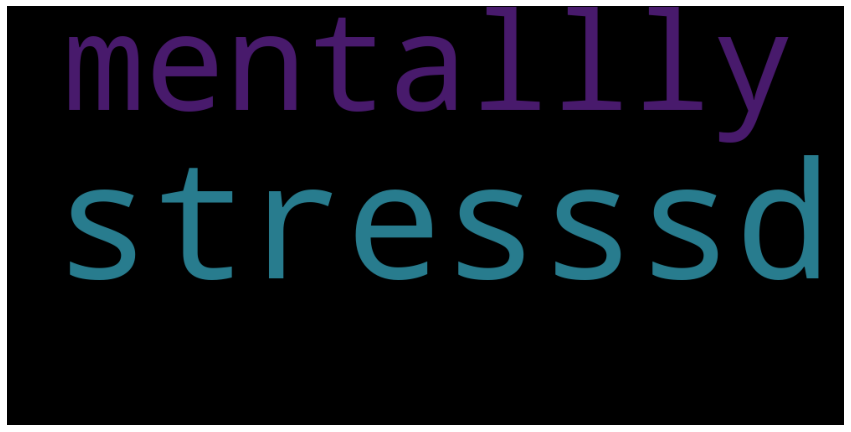

mental_wellness_causes
activity_mental_wellness
limitation_reason
first_task_when_stress
alternative_task_stress
importance_talking_someone_reason
merge_companion_reason
counselling_help_reason


In [0]:
for column in cleaning_df:
    print(column)
    try:
        eda_consecutive(list(cleaning_df[column]))
    except:
        continue

##### Looking at words with length of 2

In [0]:
for column in cleaning_df:
    print(column)
    try:
        eda_word_length_2(list(cleaning_df[column]))
    except:
        continue

first_word
second_word
third_word
importance_mental_wellness_reason
mental_wellness_causes
activity_mental_wellness
limitation_reason
first_task_when_stress
alternative_task_stress
importance_talking_someone_reason
merge_companion_reason
counselling_help_reason


##### Looking at words with length of 1 and are alphabets

In [0]:
for column in cleaning_df:
    print(column)
    try:
        eda_word_length_1(list(cleaning_df[column]))
    except:
        continue

first_word
second_word
third_word
importance_mental_wellness_reason
mental_wellness_causes
activity_mental_wellness
limitation_reason
first_task_when_stress
alternative_task_stress
importance_talking_someone_reason
merge_companion_reason
counselling_help_reason


### EDA of Survey Data

#### Stakeholder 

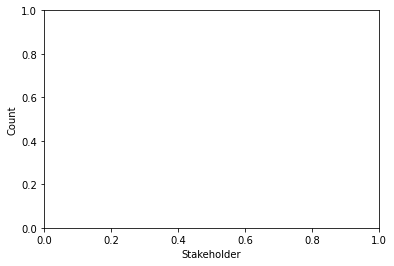

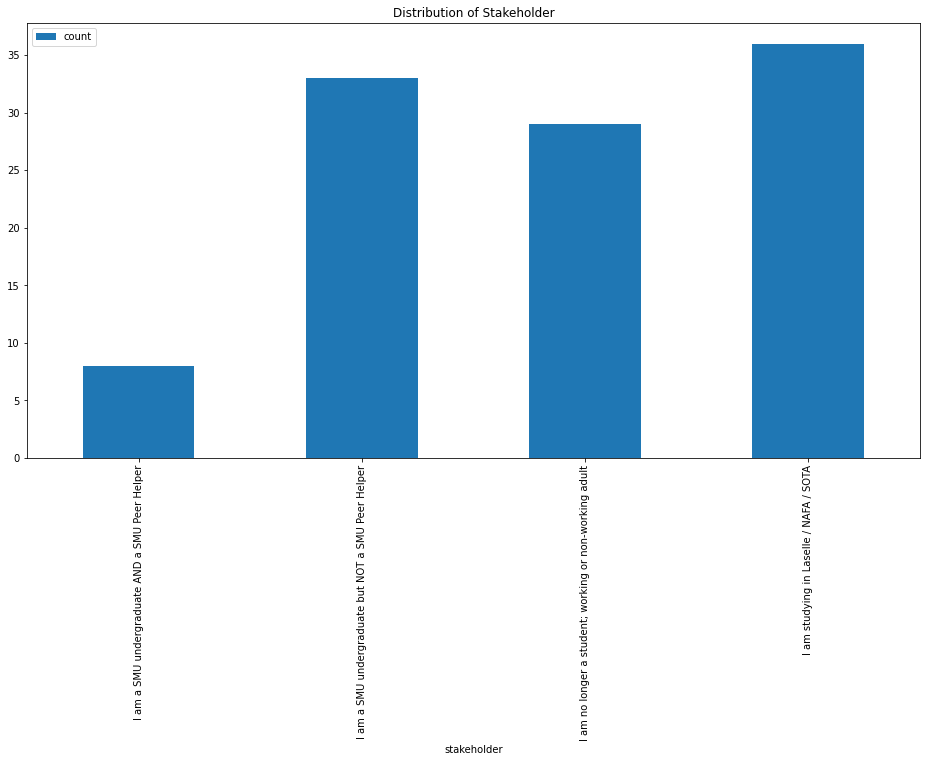

In [0]:
fig, ax1 = plt.subplots()
stakeholder_df = survey_df.groupby('stakeholder').size().reset_index(name='count')
stakeholder_df[['stakeholder','count']].plot(kind='bar', figsize=(16,8), title='Distribution of Stakeholder',x='stakeholder',y='count')
ax1.set_ylabel("Count")
ax1.set_xlabel('Stakeholder')
plt.show()

#### Gender

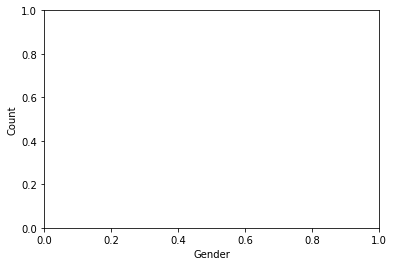

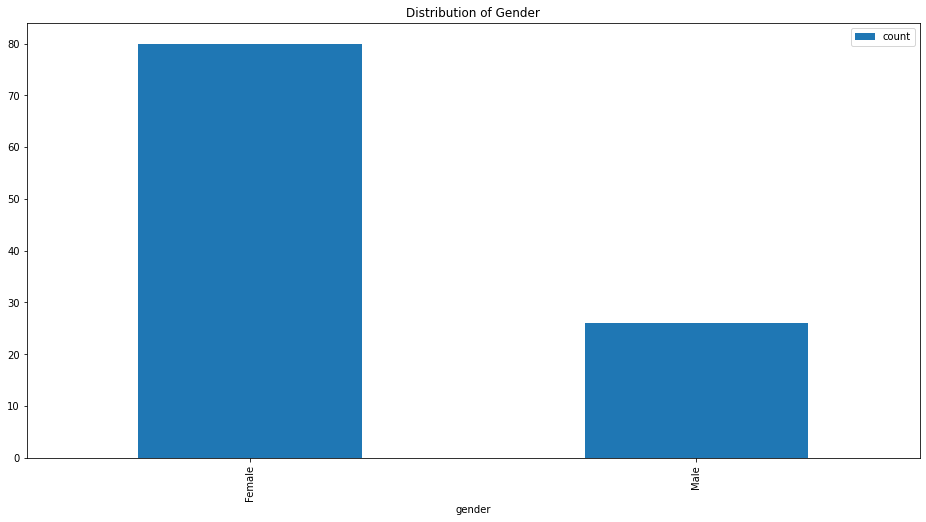

In [0]:
fig, ax1 = plt.subplots()
stakeholder_df = survey_df.groupby('gender').size().reset_index(name='count')
stakeholder_df[['gender','count']].plot(kind='bar', figsize=(16,8), title='Distribution of Gender',x='gender',y='count')
ax1.set_ylabel("Count")
ax1.set_xlabel('Gender')
plt.show()

#### Age

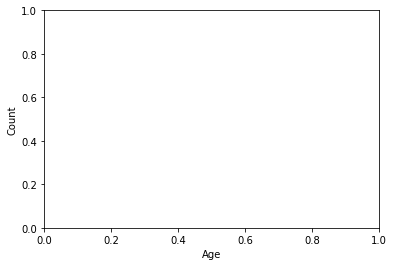

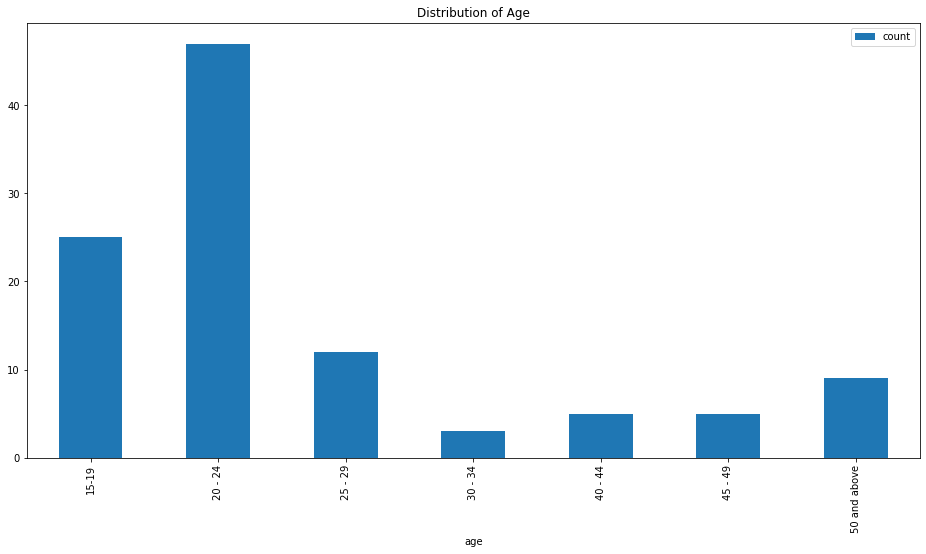

In [0]:
fig, ax1 = plt.subplots()
stakeholder_df = survey_df.groupby('age').size().reset_index(name='count')
stakeholder_df[['age','count']].plot(kind='bar', figsize=(16,8), title='Distribution of Age',x='age',y='count')
ax1.set_ylabel("Count")
ax1.set_xlabel('Age')
plt.show()

#### Household Income

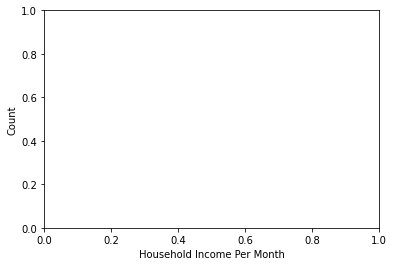

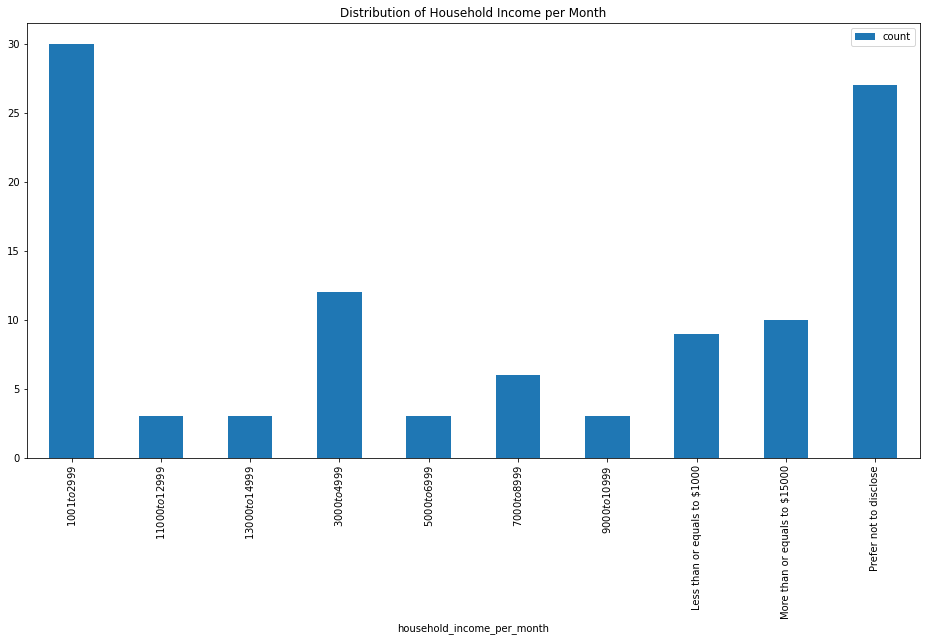

In [0]:
fig, ax1 = plt.subplots()
stakeholder_df = survey_df.groupby('household_income_per_month').size().reset_index(name='count')
stakeholder_df[['household_income_per_month','count']].plot(kind='bar', figsize=(16,8), title='Distribution of Household Income per Month',x='household_income_per_month',y='count')
ax1.set_ylabel("Count")
ax1.set_xlabel('Household Income Per Month')
plt.show()

#### EDA of other MCQ

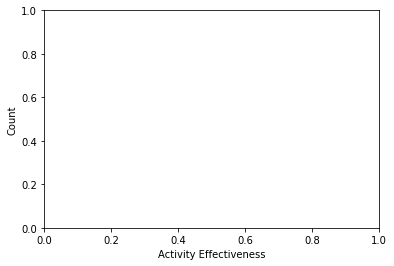

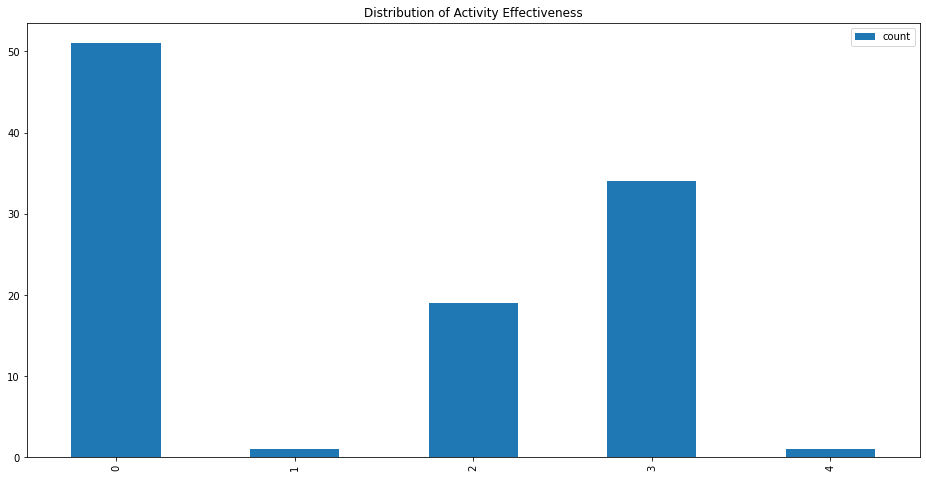

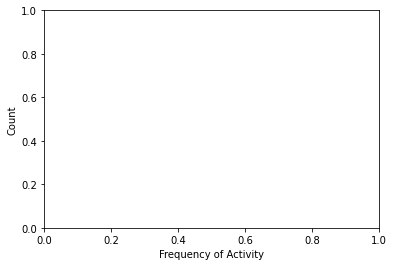

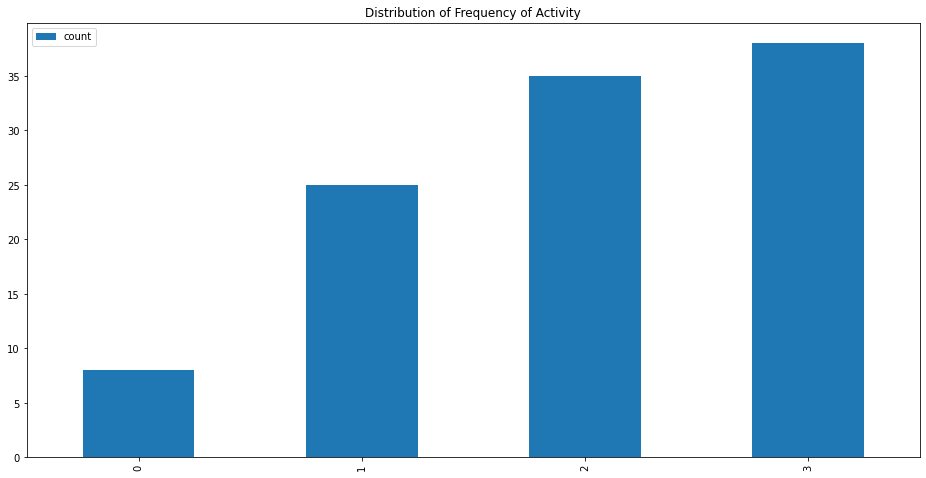

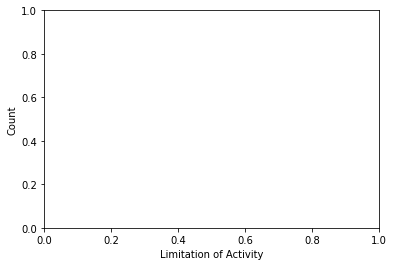

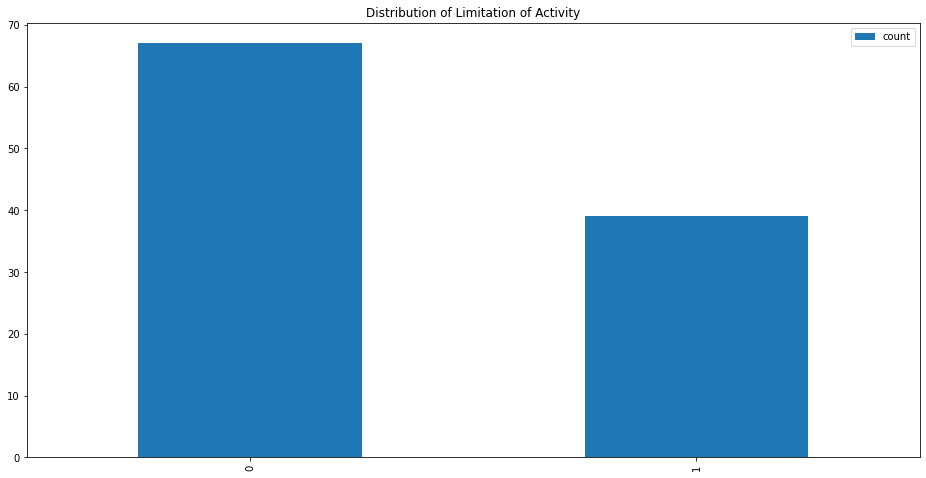

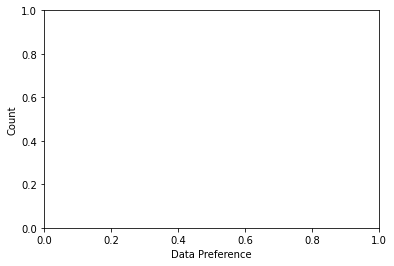

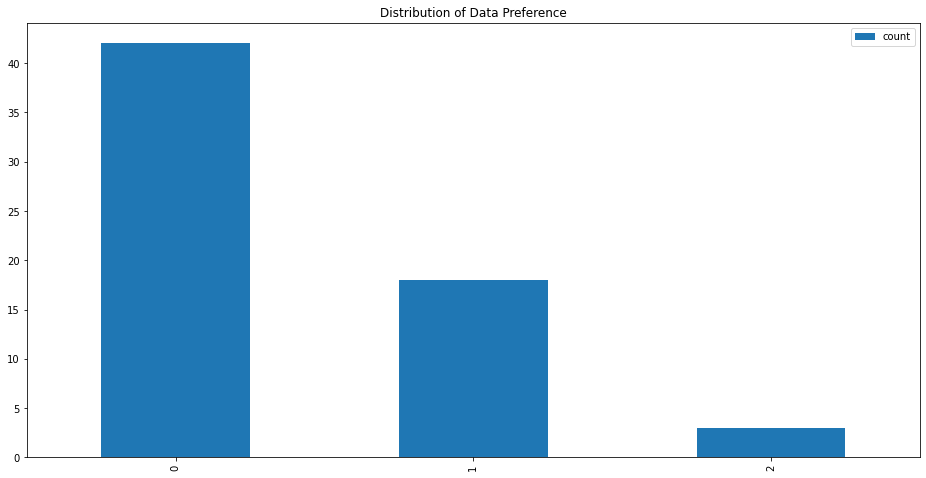

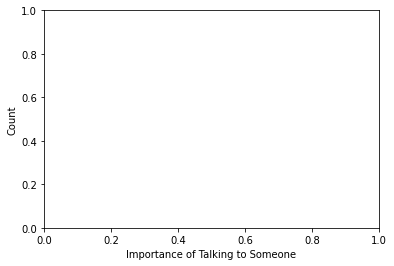

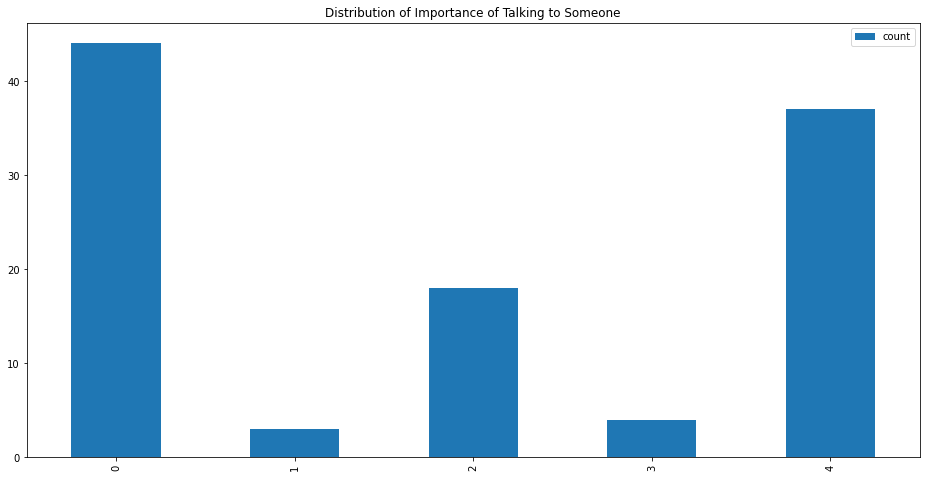

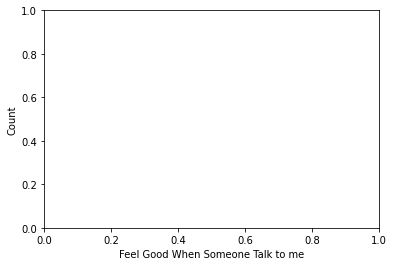

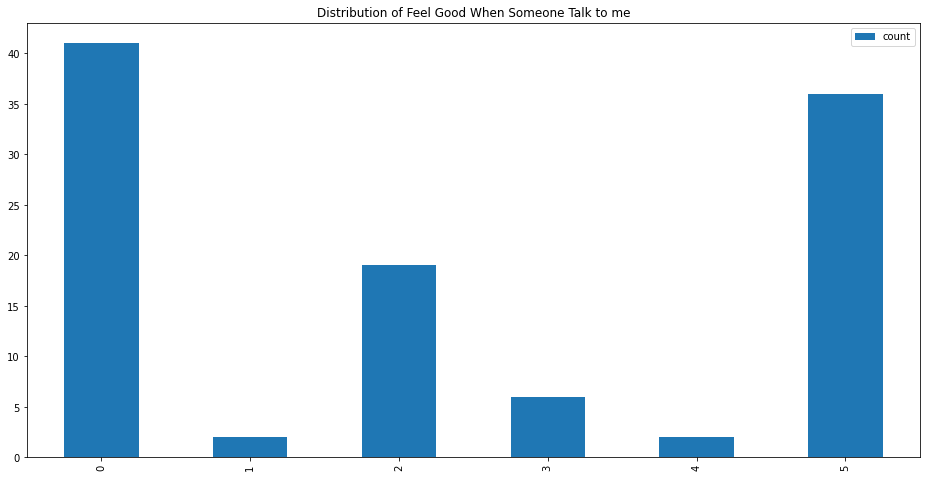

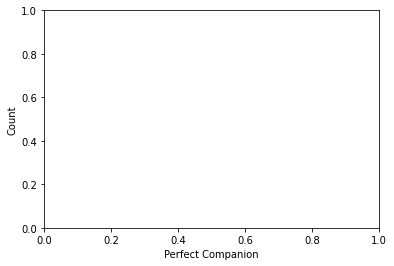

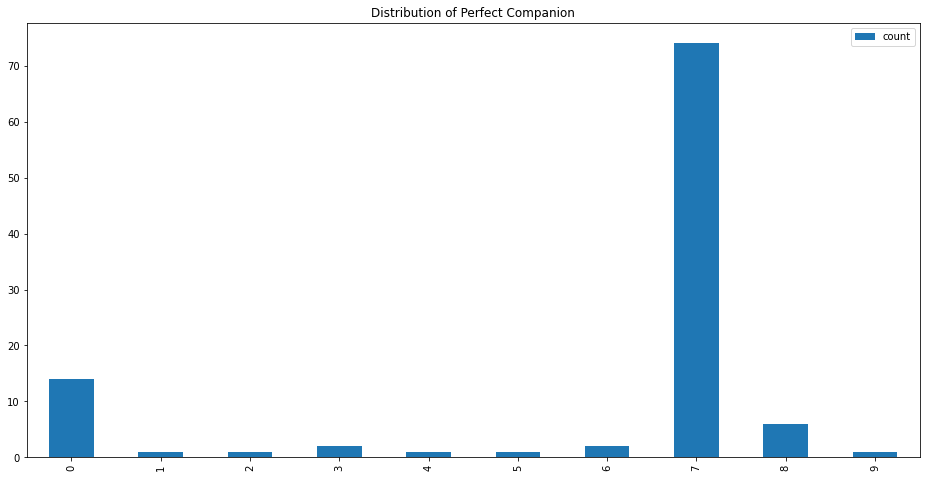

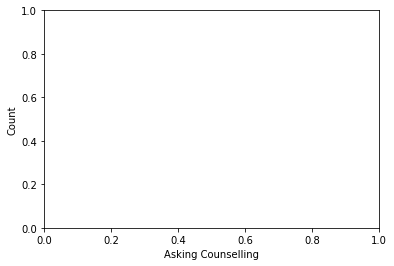

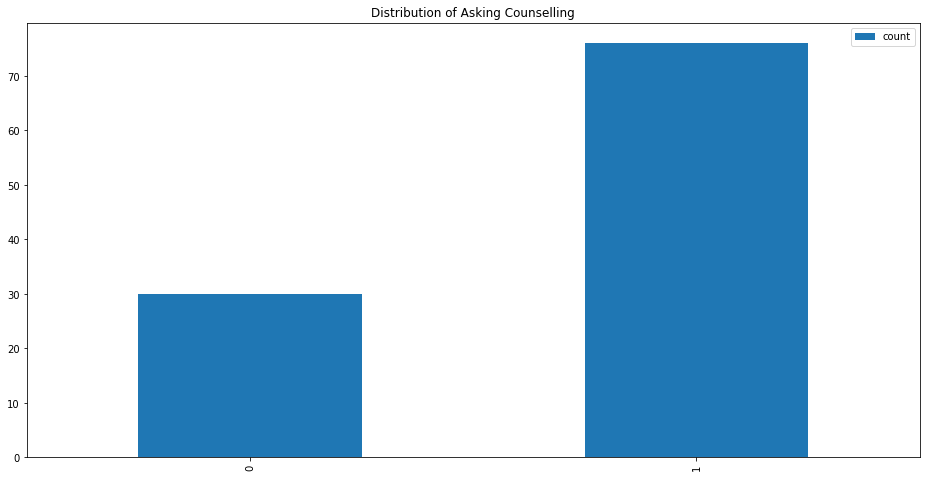

In [0]:
title_mapping = {'activity_effectiveness':'Distribution of Activity Effectiveness', 'activity_frequency':'Distribution of Frequency of Activity',
                 'binary_activity_limitation':'Distribution of Limitation of Activity', 'data_preference':'Distribution of Data Preference',
       'importance_talking_someone':'Distribution of Importance of Talking to Someone', 'feel_good':'Distribution of Feel Good When Someone Talk to me', 
       'perfect_companion':'Distribution of Perfect Companion', 'counselling_help':'Distribution of Asking Counselling'}

label_mapping = {'activity_effectiveness':'Activity Effectiveness', 'activity_frequency':'Frequency of Activity',
                 'binary_activity_limitation':'Limitation of Activity', 'data_preference':'Data Preference',
       'importance_talking_someone':'Importance of Talking to Someone', 'feel_good':'Feel Good When Someone Talk to me', 
       'perfect_companion':'Perfect Companion', 'counselling_help':'Asking Counselling'}

for column in ['activity_effectiveness', 'activity_frequency','binary_activity_limitation', 'data_preference',
       'importance_talking_someone', 'feel_good', 'perfect_companion', 'counselling_help']:
    fig, ax1 = plt.subplots()
    stakeholder_df = survey_df.groupby(column).size().reset_index(name='count')
    stakeholder_df[[column,'count']].plot(kind='bar', figsize=(16,8), title=title_mapping[column],y='count')
    ax1.set_ylabel("Count")
    ax1.set_xlabel(label_mapping[column])
    plt.show()

### Retrieve words for Crawling

In [0]:
current_keywords = ['stress','pressure','mental tension', 'mental strain', 'overworked', 'frustration', 
                    'tired','depressed', 'sad', 'dejected', 'despair', 'antidepressant', 'burnout', 
                    'emptiness', 'insomnia', 'depression','suicide', 'samaritans of singapore','sos', 
                    'die', 'burden', 'worthlessness','anxiety', 'worry', 'apprehension', 'distress', 'panic', 
                    'hyperventilation', 'helpless', 'hyperventilate']


words = list(survey_df['first_word']) + list(survey_df['second_word']) + list(survey_df['third_word'])
words = list(([lower_case(word.strip()) for word in words]))
words = [word for word in words if word not in current_keywords]
words = dict(Counter(words))
unigrams = [word for word in words if len(word_tokenize(word)) == 1]
not_unigrams = [word for word in words if len(word_tokenize(word)) > 1]
words = sorted(words.items(), key=operator.itemgetter(1),reverse=True)
print('Unique Words:\n',words)
print('\nUnique Uni-grams:\n',unigrams)
print('\nUnique Bi-grams and above:\n',not_unigrams)

filtered_unigrams = ['therapy', 'peace', 'crazy', 'stigma', 'imh', 'insane','stress-free', 'bullying', 'self-being', 
                     'anger', 'undepressed', 'counselling', 'disorder', 'meditation', 'psychological', 'resilience', 
                     'confusion','psychology', 'contentment', 'struggle', 'bipolar', 'counsellor', 'insecurities', 
                     'self-care', 'sanity', 'messy', 'lonely', 'spirituality','depress', 'serenity', 'warmth', 
                     'dissatisfaction', 'unanxious']

final_keywords = current_keywords + not_unigrams + filtered_unigrams
print('\nFinal Keywords:\n',final_keywords)

Unique Words:
 [('happy', 10), ('health', 8), ('peace', 7), ('therapy', 6), ('self care', 6), ('help', 6), ('happiness', 5), ('positive', 5), ('resilience', 5), ('awareness', 4), ('relaxation', 4), ('relax', 4), ('counselling', 4), ('support', 3), ('stigma', 3), ('mind', 3), ('important', 3), ('rest', 3), ('healthy', 3), ('mental health', 3), ('mindfulness', 3), ('psychology', 3), ('self-care', 3), ('strength', 3), ('crazy', 2), ('sick', 2), ('mindset', 2), ('thankful', 2), ('positivity', 2), ('stress-free', 2), ('misunderstood', 2), ('necessary', 2), ('balance', 2), ('contentment', 2), ('calmness', 2), ('loneliness', 2), ('well being', 2), ('listening', 2), ('joy', 2), ('love for oneself', 1), ('confidence', 1), ('cognitive', 1), ('good social relationships', 1), ('welfare', 1), ('calm', 1), ('heart', 1), ('fear', 1), ('unwell', 1), ('postive', 1), ('imh', 1), ('insane', 1), ('emotional regulations', 1), ('alone', 1), ('good', 1), ('social anxiety', 1), ('unnoticed', 1), ('strong', 1)

#### Cleaning

In [0]:
cleaned_text = []
for column in cleaning_df:
    new_column = 'cleaned_' + column
    cleaned_text.append(new_column)
    cleaning_df[column].fillna('',inplace=True)
    survey_df[new_column] = clean_text(list(cleaning_df[column]))
    survey_df.drop(column,inplace=True,axis=1)

survey_df.to_csv('Mental Wellness Survey (Clean).csv',index=False)

#### Load cleaned Dataset

In [0]:
survey_df = pd.read_csv('Mental Wellness Survey (Clean).csv')
survey_df = survey_df.fillna('')
survey_df.head()

,name,stakeholder,gender,age,race,household_income_per_month,district,school,importance_mental_wellness,mental_wellness_activities,activity_effectiveness,activity_frequency,binary_activity_limitation,data_preference,importance_talking_someone,feel_good,perfect_companion,counselling_help,counselling_center_friends,peer_helper_exp,participation_month,student_issue,peer_helper_technique,connexion,entertainment_events,education_events,sport_event,cleaned_first_word,cleaned_second_word,cleaned_third_word,cleaned_importance_mental_wellness_reason,cleaned_mental_wellness_causes,cleaned_activity_mental_wellness,cleaned_limitation_reason,cleaned_first_task_when_stress,cleaned_alternative_task_stress,cleaned_importance_talking_someone_reason,cleaned_merge_companion_reason,cleaned_counselling_help_reason
0,anonymous1,I am a SMU undergraduate but NOT a SMU Peer He...,Male,20 - 24,Chinese,$1001 to $2999,"District 12 - Toa Payoh, Serangoon, Balestier",,Strongly Important,,Slightly Effective,5 times or more,No,All of the above,Important,Agree,Artificial Intelligence - Chat Bots,No,Yes,,,,,Yes,59,19,22,stress,happy,sanity,healthy state mind depends mentally determine ...,much stress exam surveying student project,exercise play game,,talk girlfriend,gst voucher,allow open feel good,artificial intelligence bots need care bot think,troublesome
1,anonymous2,I am a SMU undergraduate but NOT a SMU Peer He...,Male,20 - 24,Chinese,$1001 to $2999,"District 11 - Novena, Newton, Thomson",,Important,All of the above,Slightly Effective,2 times,Yes,All of the above,Important,Somewhat agree,,No,No,,,,,Yes,57,43,0,therapy,counsel,help,cannot function,stress,break look device,difficult busy,talk people,counsel,avenue distress,,stigma
2,anonymous3,I am a SMU undergraduate but NOT a SMU Peer He...,Male,20 - 24,Chinese,$13000 to $14999,"District 11 - Novena, Newton, Thomson",,Important,Singapore as a whole,Effective,3 to 4 times,No,,Strongly Important,Agree,Human,No,No,,,,,Yes,35,53,12,depression,anxiety,stress,person need mentally motivate thrive,society peer family pressure school get job co...,exercise netflix chill sex warm shower hang fr...,,self reflect seek help plan overcome,seek professional help little expensive,feel good rant get advice,human,expensive
3,anonymous5,I am a SMU undergraduate but NOT a SMU Peer He...,Female,20 - 24,Chinese,Less than or equals to $1000,"District 19 - Punggol, Sengkang, Serangoon Gar...",,Slightly Important,,Effective,2 times,No,,Important,Disagree,Animated Objects,No,No,,,,,Yes,100,0,0,crazy,joker,messy,wont commit suicide,academic peer job,drama movie marathon,,cry,increase awareness,need validation feeling,animated object otaku,try reach available lose faith
4,anonymous6,I am studying in Laselle / NAFA / SOTA,Female,20 - 24,Chinese,$5000 to $6999,"District 25 - Woodlands, Admiralty",Nanyang Academy of Fine Arts (NAFA),Important,,Effective,1 time,No,,Important,Somewhat disagree,A Pet,No,No,,,,,No,25,75,0,crazy,stress,suicide,course sanity important,stress people get hereditary,meditate,,talk pet,pet,sometimes need people listen,pet win judge pet always available,think need


### Data Wrangling

#### Drop unused columns

In [0]:
survey_df.drop(['peer_helper_exp','participation_month','student_issue','peer_helper_technique','mental_wellness_activities','data_preference'],inplace=True,axis=1)

#### Map District to Region

In [0]:
display(survey_df['district'].value_counts())

District 19 - Punggol, Sengkang, Serangoon Gardens                               21
District 18 - Tampines, Pasir Ris                                                13
District 12 - Toa Payoh, Serangoon, Balestier                                     9
District 23 - Choa Chu Kang, Diary Farm, Hillview, Bukit Panjang, Bukit Batok     8
District 27 - Sembawang, Yishun, Admiralty                                        7
District 16 - Bedok, Upper East Coast, Siglap                                     6
District 25 - Woodlands, Admiralty                                                6
District 20 - Ang Mo Kio, Bishan, Thomson                                         5
District 10 - Bukit Timah, Holland, Balmoral                                      5
District 14 - Geylang, Paya Lebar, Sims                                           4
District 05 - Buona Vista, Pasir Panjang, Clementi                                3
District 03 - Tiong Bahru, Alexandra, Queenstown                            

In [0]:
district_mapping = {'Central Region':['District 01 - Raffles Place, Marina, Cecil','District 02 - Tanjong Pager, Chinatown','District 03 - Tiong Bahru, Alexandra, Queenstown','District 04 - Mount Faber, Telok Blangah, Harbourfront','District 05 - Buona Vista, Pasir Panjang, Clementi','District 06 - Clarke Quay, City Hall','District 07 - Bugis, Beach Road, Golden Mile','District 08 - Little India, Farrer Park','District 09 - Orchard Road, River Valley','District 10 - Bukit Timah, Holland, Balmoral','District 11 - Novena, Newton, Thomson','District 12 - Toa Payoh, Serangoon, Balestier','District 13 - Macpherson, Braddell','District 14 - Geylang, Paya Lebar, Sims','District 15 - Joo Chiat, Marina Parade, Katong','District 21 - Upper Bukit Timah, Ulu Pandan, Clementi Park'],
                    'East Region':['District 16 - Bedok, Upper East Coast, Siglap','District 17 - Changi, Flora, Loyang','District 18 - Tampines, Pasir Ris'],
                    'North-East Region':['District 19 - Punggol, Sengkang, Serangoon Gardens','District 20 - Ang Mo Kio, Bishan, Thomson','District 28 - Yio Chu Kang, Seletar'],
                    'West Region':['District 22 - Boon Lay, Jurong, Tuas','District 23 - Choa Chu Kang, Diary Farm, Hillview, Bukit Panjang, Bukit Batok','District 24 - Kranji, Lim Chu Kang, Tengah'],
                    'North Region':['District 25 - Woodlands, Admiralty','District 26 - Upper Thomson, Mandai','District 27 - Sembawang, Yishun, Admiralty']}

In [0]:
regions = []

for district in survey_df['district']:
    for region,districts in district_mapping.items():
        if district in districts:
            if region == 'Central Region':
                regions.append(1)
            else:
                regions.append(0)


survey_df['region'] = regions
display(survey_df['region'].value_counts())
survey_df.drop('district',inplace=True,axis=1)

0    69
1    37
Name: region, dtype: int64

#### Age

In [0]:
survey_df['age'].value_counts()

20 - 24         47
15-19           25
25 - 29         12
50 and above     9
45 - 49          5
40 - 44          5
30 - 34          3
Name: age, dtype: int64

In [0]:
age_mapping = ['25 - 29','30 - 34','40 - 44','45 - 49','50 and above']

new_age = []
for index, row in survey_df.iterrows():
    if row['age'] in age_mapping:
        # new_age.append('25 and above')
        new_age.append(0)
    else:
        # new_age.append(row['age'])
        new_age.append(1)

survey_df['new_age'] = new_age
display(survey_df['new_age'].value_counts())

survey_df.drop('age',axis=1,inplace=True)

1    72
0    34
Name: new_age, dtype: int64

#### Stakeholders

In [0]:
survey_df['stakeholder'].value_counts()

I am studying in Laselle / NAFA / SOTA                    36
I am a SMU undergraduate but NOT a SMU Peer Helper        33
I am no longer a student; working or non-working adult    29
I am a SMU undergraduate AND a SMU Peer Helper             8
Name: stakeholder, dtype: int64

In [0]:
stakeholder_mapping = {'I am a SMU undergraduate AND a SMU Peer Helper':1,
                      'I am a SMU undergraduate but NOT a SMU Peer Helper':1,
                      "I am studying in Laselle / NAFA / SOTA":0,
                      "I am no longer a student; working or non-working adult":0}

new_stakeholders = []
for index,row in survey_df.iterrows():
    for current,new in stakeholder_mapping.items():
        if row['stakeholder'] == current:
            new_stakeholders.append(new)

survey_df['new_stakeholder'] = new_stakeholders
display(survey_df['new_stakeholder'].value_counts())
survey_df.drop(['school','stakeholder'],axis=1,inplace=True)

0    65
1    41
Name: new_stakeholder, dtype: int64

#### Income

In [0]:
survey_df['household_income_per_month'].value_counts()

$1001 to $2999                   30
Prefer not to disclose           27
$3000 to $4999                   12
More than or equals to $15000    10
Less than or equals to $1000      9
$7000 to $8999                    6
$9000 to $10999                   3
$13000 to $14999                  3
$11000 to $12999                  3
$5000 to $6999                    3
Name: household_income_per_month, dtype: int64

In [0]:
new_household_income_per_month = []


for index,row in survey_df.iterrows():
    if row['household_income_per_month'] == 'Less than or equals to $1000' or row['household_income_per_month'] == '$1001 to $2999':
        new_household_income_per_month.append('$0.01 to $2999')
    elif row['household_income_per_month'] == '$3000 to $4999' or row['household_income_per_month'] == '$5000 to $6999' or row['household_income_per_month'] == '$7000 to $8999':
        new_household_income_per_month.append('$3000 to $8999')
    elif row['household_income_per_month'] == '$9000 to $10999' or row['household_income_per_month'] == '$11000 to $12999' or row['household_income_per_month'] == '$13000 to $14999' or row['household_income_per_month'] == 'More than or equals to $15000':
        new_household_income_per_month.append('More than $9000')
    else:
        new_household_income_per_month.append(row['household_income_per_month'])
        
survey_df['new_household_income_per_month'] = new_household_income_per_month
print()
display(survey_df['new_household_income_per_month'].value_counts())
survey_df.drop('household_income_per_month',axis=1,inplace=True)

$0.01 to $2999            39
Prefer not to disclose    27
$3000 to $8999            21
More than $9000           19
Name: new_household_income_per_month, dtype: int64

#### Race

In [0]:
survey_df['race'].value_counts()

Chinese       95
Malay          6
Indian         2
Caucasian      1
Burmese        1
Eurasian       1
Name: race, dtype: int64

In [0]:
chinese = []

for index,row in survey_df.iterrows():
    if row['race'] == 'Chinese':
        chinese.append(1)
    else:
        chinese.append(0)

survey_df['chinese'] = chinese
display(survey_df['chinese'].value_counts())
survey_df.drop('race',inplace=True,axis=1)

1    95
0    11
Name: chinese, dtype: int64

#### Companion

In [0]:
survey_df['perfect_companion'].value_counts()

Human                                  74
A Pet                                  14
Music Instrument(s)                     6
                                        3
Artificial Intelligence - Chat Bots     2
God                                     2
Personal                                1
Drama                                   1
All of the above                        1
Comfortable Space                       1
Animated Objects                        1
Name: perfect_companion, dtype: int64

In [0]:
companion_types = []
companion_living_subtypes = []
companion_non_living_subtypes = []

companion_type_mapping = {'Non-Living':0,'Living':1}

for index,row in survey_df.iterrows():
    if row['perfect_companion'] == 'Human' or row['perfect_companion'] == 'A Pet' or row['perfect_companion'] == 'All of the above':
        companion_type = companion_type_mapping['Living']
    else:
        companion_type = companion_type_mapping['Non-Living']
    companion_types.append(companion_type)
        
survey_df['companion_types'] = companion_types
display(survey_df['companion_types'].value_counts())
print()
survey_df.drop('perfect_companion',axis=1,inplace=True)

1    89
0    17
Name: companion_types, dtype: int64

#### Map Binary

In [0]:
binary_mapping = {'Yes':1,'No':0}
# binary_mapping = {'Yes':1,'No':-1}

new_binary_activity_limitation = []
new_counselling_help = []
new_connexion = []
new_counselling_center_friends = []
for index,row in survey_df.iterrows():
    new_binary_activity_limitation.append(binary_mapping[row['binary_activity_limitation']])
    new_counselling_help.append(binary_mapping[row['counselling_help']])
    new_connexion.append(binary_mapping[row['connexion']])
    new_counselling_center_friends.append(binary_mapping[row['counselling_center_friends']])

survey_df['new_binary_activity_limitation'] = new_binary_activity_limitation
survey_df['new_counselling_help'] = new_counselling_help
survey_df['new_connexion'] = new_connexion
survey_df['new_counselling_center_friends'] = new_counselling_center_friends
display(survey_df['new_binary_activity_limitation'].value_counts())
display(survey_df['new_counselling_help'].value_counts())
display(survey_df['new_connexion'].value_counts())
display(survey_df['new_counselling_center_friends'].value_counts())
survey_df.drop(['binary_activity_limitation','counselling_help','connexion','counselling_center_friends'],axis=1,inplace=True)

0    67
1    39
Name: new_binary_activity_limitation, dtype: int64

1    76
0    30
Name: new_counselling_help, dtype: int64

0    61
1    45
Name: new_connexion, dtype: int64

1    56
0    50
Name: new_counselling_center_friends, dtype: int64

#### Map Gender

In [0]:
gender_mapping = {'Female':0,'Male':1}

new_gender = []
for index,row in survey_df.iterrows():
    new_gender.append(gender_mapping[row['gender']])

survey_df['new_gender'] = new_gender
display(survey_df['new_gender'].value_counts())
survey_df.drop('gender',inplace=True,axis=1)

0    80
1    26
Name: new_gender, dtype: int64

#### Map Importance

In [0]:
new_importance_mental_wellness = []
new_importance_talking_someone = []

for index,row in survey_df.iterrows():
    if 'Not Important' in row['importance_mental_wellness']:
        # new_importance_mental_wellness.append(-1)
        new_importance_mental_wellness.append(0)
    else:
        new_importance_mental_wellness.append(1)
    if 'Not Important' in row['importance_talking_someone']:
        # new_importance_talking_someone.append(-1)
        new_importance_talking_someone.append(0)
    else:
        new_importance_talking_someone.append(1)


survey_df['new_importance_mental_wellness'] = new_importance_mental_wellness
survey_df['new_importance_talking_someone'] = new_importance_talking_someone
display(survey_df['new_importance_mental_wellness'].value_counts())
print()
display(survey_df['new_importance_talking_someone'].value_counts())
survey_df.drop(['importance_mental_wellness','importance_talking_someone'],inplace=True,axis=1)

1    104
0      2
Name: new_importance_mental_wellness, dtype: int64

1    99
0     7
Name: new_importance_talking_someone, dtype: int64

#### Map Agree/Disagree

In [0]:
new_feel_good = []

for index,row in survey_df.iterrows():
    if 'Disagree' in row['feel_good'] or 'disagree' in row['feel_good']:
        # new_feel_good.append(-1)
        new_feel_good.append(0)
    else:
        new_feel_good.append(1)

survey_df['new_feel_good'] = new_feel_good
display(survey_df['new_feel_good'].value_counts())
survey_df.drop('feel_good',inplace=True,axis=1)

1    96
0    10
Name: new_feel_good, dtype: int64

#### Map Effectiveness

In [0]:
new_activity_effectiveness = []

for index,row in survey_df.iterrows():
    if 'Ineffective' in row['activity_effectiveness']:
        # new_activity_effectiveness.append(-1)
        new_activity_effectiveness.append(0)
    else:
        new_activity_effectiveness.append(1)

survey_df['new_activity_effectiveness'] = new_activity_effectiveness
display(survey_df['new_activity_effectiveness'].value_counts())
survey_df.drop('activity_effectiveness',inplace=True,axis=1)

1    104
0      2
Name: new_activity_effectiveness, dtype: int64

#### Map Frequency

In [0]:
# frequency_mapping = {"None":-1,"1 time":-1,"2 times":-1,'3 to 4 times':1,"5 times or more":1}
frequency_mapping = {"None":0,"1 time":0,"2 times":0,'3 to 4 times':1,"5 times or more":1}

new_activity_frequency = []

for index,row in survey_df.iterrows():
    new_activity_frequency.append(frequency_mapping[row['activity_frequency']])

survey_df['new_activity_frequency'] = new_activity_frequency
display(survey_df['new_activity_frequency'].value_counts())
survey_df.drop('activity_frequency',inplace=True,axis=1)

1    73
0    33
Name: new_activity_frequency, dtype: int64

### Feature Engineering

#### Target Variables

In [0]:
target_columns = ['entertainment_events','education_events','sport_event']
new_target_columns = ['events_target','education_events_target','sport_event_target']

for i in range(len(target_columns)):
    column = target_columns[i]
    new_column = new_target_columns[i]
    column_median = float(survey_df[column].median())
    percentage = len(survey_df[survey_df[column] > column_median])/len(survey_df[column])*100
    if column == 'entertainment_events':
        print("{}'s median: {}".format('events',column_median))
    else:
        print("{}'s median: {}".format(column,column_median))
    print("{}'s proportion which is more than median: {}%\n".format(column,percentage))
    new_column_values = []
    for index, row in survey_df.iterrows():
        if row[column] > column_median:
            new_column_values.append(1)
        else:
            new_column_values.append(0)
    survey_df[new_column] = new_column_values

events's median: 32.5
entertainment_events's proportion which is more than median: 50.0%

education_events's median: 35.0
education_events's proportion which is more than median: 49.056603773584904%

sport_event's median: 24.5
sport_event's proportion which is more than median: 50.0%



In [0]:
for column in new_target_columns:
    display(survey_df[column].value_counts())

survey_df['final_target'] = survey_df[new_target_columns].sum(axis=1)
survey_df['final_target'][survey_df['final_target'] <= 1] = 0
survey_df['final_target'][survey_df['final_target'] > 1] = 1
display(survey_df['final_target'].value_counts())
display(survey_df)

survey_df.drop(new_target_columns + target_columns,axis=1,inplace=True)

1    53
0    53
Name: events_target, dtype: int64

0    54
1    52
Name: education_events_target, dtype: int64

1    53
0    53
Name: sport_event_target, dtype: int64

0    54
1    52
Name: final_target, dtype: int64

,name,entertainment_events,education_events,sport_event,cleaned_first_word,cleaned_second_word,cleaned_third_word,cleaned_importance_mental_wellness_reason,cleaned_mental_wellness_causes,cleaned_activity_mental_wellness,cleaned_limitation_reason,cleaned_first_task_when_stress,cleaned_alternative_task_stress,cleaned_importance_talking_someone_reason,cleaned_merge_companion_reason,cleaned_counselling_help_reason,region,new_age,new_stakeholder,new_household_income_per_month,chinese,companion_types,new_binary_activity_limitation,new_counselling_help,new_connexion,new_counselling_center_friends,new_gender,new_importance_mental_wellness,new_importance_talking_someone,new_feel_good,new_activity_effectiveness,new_activity_frequency,events_target,education_events_target,sport_event_target,final_target
0,anonymous1,59,19,22,stress,happy,sanity,healthy state mind depends mentally determine ...,much stress exam surveying student project,exercise play game,,talk girlfriend,gst voucher,allow open feel good,artificial intelligence bots need care bot think,troublesome,1,1,1,$0.01 to $2999,1,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0
1,anonymous2,57,43,0,therapy,counsel,help,cannot function,stress,break look device,difficult busy,talk people,counsel,avenue distress,,stigma,1,1,1,$0.01 to $2999,1,0,1,0,1,0,1,1,1,1,1,0,1,1,0,1
2,anonymous3,35,53,12,depression,anxiety,stress,person need mentally motivate thrive,society peer family pressure school get job co...,exercise netflix chill sex warm shower hang fr...,,self reflect seek help plan overcome,seek professional help little expensive,feel good rant get advice,human,expensive,1,1,1,More than $9000,1,1,0,0,1,0,1,1,1,1,1,1,1,1,0,1
3,anonymous5,100,0,0,crazy,joker,messy,wont commit suicide,academic peer job,drama movie marathon,,cry,increase awareness,need validation feeling,animated object otaku,try reach available lose faith,0,1,1,$0.01 to $2999,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0
4,anonymous6,25,75,0,crazy,stress,suicide,course sanity important,stress people get hereditary,meditate,,talk pet,pet,sometimes need people listen,pet win judge pet always available,think need,0,1,0,$3000 to $8999,1,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,anonymous112,50,36,14,therapy,listen,depression,believe important part health whole neglect,improper bad management inability manage emoti...,take mindful feeling practice care object make...,,pray,destigmatise mental wellness sure,depends manage,human able interaction empathy emotion,negative stigma counsellor,1,1,1,$0.01 to $2999,1,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1
102,anonymous130,30,45,25,,love,warmth,believe mental wellness really important espec...,think possible range stress emotional stress w...,take sometime sit alone alway noise away hustl...,,breathe close eye,think vocal mental wellness easily confuse men...,believe heartfelt conversation people hear see...,human early answer strong believer conversatio...,professional equip knowledge handle necessary ...,0,1,0,More than $9000,1,1,0,1,0,1,0,1,1,1,1,1,0,1,1,1
103,anonymous131,80,10,10,anger,stress,dissatisfaction,mood people child motivation work,stress colleague hear disappointment negative ...,walk good cup coffee sit window simply star pa...,friend sure appropriate share thought share th...,sleep,impose labour law work france law bar email work,simply let thought articulate struggle get see...,music instrument know feel appropriate,people help good nobody stranger talk good non...,1,0,0,Prefer not to disclose,1,0,1,1,1,1,0,1,1,0,1,1,1,0,0,0
104,anonymous132,100,0,0,undepressed,function,unanxious,felt long hope others good state mind want help,school family trouble,try talk friend rant,friend get hate start talk,eliminate stress example schoolwork complain f...,honestly even know everyone uptight teenager e...,mean feel shame share struggle get understand ...,human friend truly understan

#### Load Gazette

In [0]:
gazette_df = pd.read_csv('gazette v2.csv')
gazette_df['clean_word'] = clean_text(gazette_df['word'])
gazette_df

,column,word,clean_word
0,three_words,depression,depression
1,three_words,stress,stress
2,three_words,anxiety,anxiety
3,three_words,self-care,
4,three_words,rest,rest
...,...,...,...
99,cleaned_counselling_help_reason,seek,seek
100,cleaned_counselling_help_reason,personal,personal
101,cleaned_counselling_help_reason,stigma,stigma
102,cleaned_counselling_help_reason,advise,advise


#### Fuzzy Matching 3 Words

In [0]:
start = time.process_time()

contents = gazette_df[gazette_df['column'] == 'three_words']['word']

fuzzy_scores = []
for index,row in survey_df.iterrows():
    fuzzy_score = 0
    for column in ['cleaned_first_word','cleaned_second_word','cleaned_third_word']:
        words = {1:[],2:[],3:[],4:[]}
        feedback = row[column]
        if feedback != '':
            for i in range(1,5):
                grams = ngrams(feedback.split(), i)

                for gram in grams:
                    words[i].append(' '.join(gram))
            max_score = 0
            for content in contents:
                length = len(content.split())
                
                for word in words[length]:
                    score = fuzz.ratio(word,content)
                    if score > max_score:
                        max_score = score
            fuzzy_score += (max_score/100)
        else:
            fuzzy_score += 0    
    

    fuzzy_scores.append(fuzzy_score/3)

# survey_df['fuzzy_similarity_three_words'] = pd.qcut(fuzzy_scores,2,labels=[0, 1])
median = np.median(fuzzy_scores)
values = [1 if value >= 0.6 else 0 for value in fuzzy_scores]
survey_df['fuzzy_similarity_three_words'] = values
survey_df.drop(['cleaned_first_word','cleaned_second_word','cleaned_third_word'],inplace=True,axis=1)

print('Run Time: {} seconds'.format(str((time.process_time() - start))))
display(survey_df)

Run Time: 0.13474290799999977 seconds


,name,cleaned_importance_mental_wellness_reason,cleaned_mental_wellness_causes,cleaned_activity_mental_wellness,cleaned_limitation_reason,cleaned_first_task_when_stress,cleaned_alternative_task_stress,cleaned_importance_talking_someone_reason,cleaned_merge_companion_reason,cleaned_counselling_help_reason,region,new_age,new_stakeholder,new_household_income_per_month,chinese,companion_types,new_binary_activity_limitation,new_counselling_help,new_connexion,new_counselling_center_friends,new_gender,new_importance_mental_wellness,new_importance_talking_someone,new_feel_good,new_activity_effectiveness,new_activity_frequency,final_target,fuzzy_similarity_three_words
0,anonymous1,healthy state mind depends mentally determine ...,much stress exam surveying student project,exercise play game,,talk girlfriend,gst voucher,allow open feel good,artificial intelligence bots need care bot think,troublesome,1,1,1,$0.01 to $2999,1,0,0,0,1,1,1,1,1,1,1,1,0,1
1,anonymous2,cannot function,stress,break look device,difficult busy,talk people,counsel,avenue distress,,stigma,1,1,1,$0.01 to $2999,1,0,1,0,1,0,1,1,1,1,1,0,1,1
2,anonymous3,person need mentally motivate thrive,society peer family pressure school get job co...,exercise netflix chill sex warm shower hang fr...,,self reflect seek help plan overcome,seek professional help little expensive,feel good rant get advice,human,expensive,1,1,1,More than $9000,1,1,0,0,1,0,1,1,1,1,1,1,1,1
3,anonymous5,wont commit suicide,academic peer job,drama movie marathon,,cry,increase awareness,need validation feeling,animated object otaku,try reach available lose faith,0,1,1,$0.01 to $2999,1,0,0,0,1,0,0,1,1,0,1,0,0,0
4,anonymous6,course sanity important,stress people get hereditary,meditate,,talk pet,pet,sometimes need people listen,pet win judge pet always available,think need,0,1,0,$3000 to $8999,1,1,0,0,0,0,0,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,anonymous112,believe important part health whole neglect,improper bad management inability manage emoti...,take mindful feeling practice care object make...,,pray,destigmatise mental wellness sure,depends manage,human able interaction empathy emotion,negative stigma counsellor,1,1,1,$0.01 to $2999,1,1,0,1,1,1,1,1,0,0,1,0,1,1
102,anonymous130,believe mental wellness really important espec...,think possible range stress emotional stress w...,take sometime sit alone alway noise away hustl...,,breathe close eye,think vocal mental wellness easily confuse men...,believe heartfelt conversation people hear see...,human early answer strong believer conversatio...,professional equip knowledge handle necessary ...,0,1,0,More than $9000,1,1,0,1,0,1,0,1,1,1,1,1,1,0
103,anonymous131,mood people child motivation work,stress colleague hear disappointment negative ...,walk good cup coffee sit window simply star pa...,friend sure appropriate share thought share th...,sleep,impose labour law work france law bar email work,simply let thought articulate struggle get see...,music instrument know feel appropriate,people help good nobody stranger talk good non...,1,0,0,Prefer not to disclose,1,0,1,1,1,1,0,1,1,0,1,1,0,1
104,anonymous132,felt long hope others good state mind want help,school family trouble,try talk friend rant,friend get hate start talk,eliminate stress example schoolwork complain f...,honestly even know everyone uptight teenager e...,mean feel shame share struggle get understand ...,human friend truly understand plight take away...,counsel centre exist,0,1,0,More than $9000,1,1,1,0,0,1,0,1,1,1,1,1,0,0


#### Fuzzy Matching Other columns

In [0]:
start = time.process_time()


content_df = gazette_df[gazette_df['column'] != 'three_words'][['column','clean_word']]

columns = list(set(content_df['column']))

fuzzy_scores = {}

for column in columns:
    fuzzy_scores[column] = []

# print(fuzzy_scores)

for index,row in survey_df.iterrows():
    for column in columns:
        contents = list(content_df.loc[content_df['column'] == column, 'clean_word'])
        contents = [word for word in contents if word != '']
        words = {1:[],2:[],3:[],4:[]}
        feedback = row[column]
        if feedback != '':
            for i in range(1,5):
                grams = ngrams(feedback.split(), i)

                for gram in grams:
                    words[i].append(' '.join(gram))
            max_score = 0
            for content in contents:
                length = len(content.split())
                
                for word in words[length]:
                    score = fuzz.ratio(word,content)
                    if score > max_score:
                        max_score = score
            fuzzy_scores[column].append(max_score/100)
        else:
            fuzzy_scores[column].append(0)    

print('Run Time: {} seconds'.format(str((time.process_time() - start))))
display(survey_df)

Run Time: 2.1005808709999982 seconds


,name,cleaned_importance_mental_wellness_reason,cleaned_mental_wellness_causes,cleaned_activity_mental_wellness,cleaned_limitation_reason,cleaned_first_task_when_stress,cleaned_alternative_task_stress,cleaned_importance_talking_someone_reason,cleaned_merge_companion_reason,cleaned_counselling_help_reason,region,new_age,new_stakeholder,new_household_income_per_month,chinese,companion_types,new_binary_activity_limitation,new_counselling_help,new_connexion,new_counselling_center_friends,new_gender,new_importance_mental_wellness,new_importance_talking_someone,new_feel_good,new_activity_effectiveness,new_activity_frequency,final_target,fuzzy_similarity_three_words
0,anonymous1,healthy state mind depends mentally determine ...,much stress exam surveying student project,exercise play game,,talk girlfriend,gst voucher,allow open feel good,artificial intelligence bots need care bot think,troublesome,1,1,1,$0.01 to $2999,1,0,0,0,1,1,1,1,1,1,1,1,0,1
1,anonymous2,cannot function,stress,break look device,difficult busy,talk people,counsel,avenue distress,,stigma,1,1,1,$0.01 to $2999,1,0,1,0,1,0,1,1,1,1,1,0,1,1
2,anonymous3,person need mentally motivate thrive,society peer family pressure school get job co...,exercise netflix chill sex warm shower hang fr...,,self reflect seek help plan overcome,seek professional help little expensive,feel good rant get advice,human,expensive,1,1,1,More than $9000,1,1,0,0,1,0,1,1,1,1,1,1,1,1
3,anonymous5,wont commit suicide,academic peer job,drama movie marathon,,cry,increase awareness,need validation feeling,animated object otaku,try reach available lose faith,0,1,1,$0.01 to $2999,1,0,0,0,1,0,0,1,1,0,1,0,0,0
4,anonymous6,course sanity important,stress people get hereditary,meditate,,talk pet,pet,sometimes need people listen,pet win judge pet always available,think need,0,1,0,$3000 to $8999,1,1,0,0,0,0,0,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,anonymous112,believe important part health whole neglect,improper bad management inability manage emoti...,take mindful feeling practice care object make...,,pray,destigmatise mental wellness sure,depends manage,human able interaction empathy emotion,negative stigma counsellor,1,1,1,$0.01 to $2999,1,1,0,1,1,1,1,1,0,0,1,0,1,1
102,anonymous130,believe mental wellness really important espec...,think possible range stress emotional stress w...,take sometime sit alone alway noise away hustl...,,breathe close eye,think vocal mental wellness easily confuse men...,believe heartfelt conversation people hear see...,human early answer strong believer conversatio...,professional equip knowledge handle necessary ...,0,1,0,More than $9000,1,1,0,1,0,1,0,1,1,1,1,1,1,0
103,anonymous131,mood people child motivation work,stress colleague hear disappointment negative ...,walk good cup coffee sit window simply star pa...,friend sure appropriate share thought share th...,sleep,impose labour law work france law bar email work,simply let thought articulate struggle get see...,music instrument know feel appropriate,people help good nobody stranger talk good non...,1,0,0,Prefer not to disclose,1,0,1,1,1,1,0,1,1,0,1,1,0,1
104,anonymous132,felt long hope others good state mind want help,school family trouble,try talk friend rant,friend get hate start talk,eliminate stress example schoolwork complain f...,honestly even know everyone uptight teenager e...,mean feel shame share struggle get understand ...,human friend truly understand plight take away...,counsel centre exist,0,1,0,More than $9000,1,1,1,0,0,1,0,1,1,1,1,1,0,0


#### Applying Weights to Fuzzy Similarity

In [0]:
weights_columns = []

for column, score in fuzzy_scores.items():
    new_column = 'fuzzy_similarity_' + column
    if column == 'cleaned_limitation_reason':
        weights = survey_df['new_binary_activity_limitation']
        weights_columns.append('new_binary_activity_limitation')
    elif column == 'cleaned_counselling_help_reason':
        weights = survey_df['new_counselling_help']
        weights_columns += ['new_counselling_help']
    elif column == 'cleaned_importance_talking_someone_reason':
        weights = survey_df['new_importance_talking_someone'] * survey_df['new_feel_good']
        weights_columns  += ['new_importance_talking_someone','new_feel_good']
    elif column == 'cleaned_importance_mental_wellness_reason':
        weights = survey_df['new_importance_mental_wellness']
        weights_columns.append('new_importance_mental_wellness')
    elif column == 'cleaned_merge_companion_reason':
        weights = survey_df['companion_types']
        weights_columns  += ['companion_types']
    # elif column == 'cleaned_activity_mental_wellness':
    #     weights = survey_df['new_activity_effectiveness'] * survey_df['new_activity_frequency']
    #     weights_columns  += ['new_activity_effectiveness','new_activity_frequency']
    try:
        values = [score[i] * weights[i] for i in range(len(score))]
    except:
        values = score
    median = np.median(values)
    values = [1 if value >= 0.5 else 0 for value in values]
    survey_df[new_column] = values

    
survey_df.drop(columns,inplace=True,axis=1)
survey_df.drop(weights_columns,inplace=True,axis=1)
display(survey_df)

,name,region,new_age,new_stakeholder,new_household_income_per_month,chinese,new_connexion,new_counselling_center_friends,new_gender,new_activity_effectiveness,new_activity_frequency,final_target,fuzzy_similarity_three_words,fuzzy_similarity_cleaned_importance_mental_wellness_reason,fuzzy_similarity_cleaned_mental_wellness_causes,fuzzy_similarity_cleaned_alternative_task_stress,fuzzy_similarity_cleaned_limitation_reason,fuzzy_similarity_cleaned_first_task_when_stress,fuzzy_similarity_cleaned_importance_talking_someone_reason,fuzzy_similarity_cleaned_counselling_help_reason,fuzzy_similarity_cleaned_merge_companion_reason,fuzzy_similarity_cleaned_activity_mental_wellness
0,anonymous1,1,1,1,$0.01 to $2999,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0
1,anonymous2,1,1,1,$0.01 to $2999,1,1,0,1,1,0,1,1,1,1,0,0,1,1,0,0,0
2,anonymous3,1,1,1,More than $9000,1,1,0,1,1,1,1,1,1,1,0,0,0,0,0,1,1
3,anonymous5,0,1,1,$0.01 to $2999,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,anonymous6,0,1,0,$3000 to $8999,1,0,0,0,1,0,0,1,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,anonymous112,1,1,1,$0.01 to $2999,1,1,1,1,1,0,1,1,1,1,1,0,0,0,1,1,1
102,anonymous130,0,1,0,More than $9000,1,0,1,0,1,1,1,0,1,1,1,0,0,0,1,1,1
103,anonymous131,1,0,0,Prefer not to disclose,1,1,1,0,1,1,0,1,1,1,1,1,0,0,1,0,0
104,anonymous132,0,1,0,More than $9000,1,0,1,0,1,1,0,0,1,1,0,1,1,1,0,1,1


### One-hot Encoding

In [0]:
survey_df = pd.get_dummies(data = survey_df, columns = ['new_household_income_per_month']) # drop_first = True)
# survey_df = pd.get_dummies(data = survey_df, columns = ['new_stakeholder','new_age',
#                                                         'new_household_income_per_month']) # drop_first = True)

### Save File

In [0]:
survey_df.to_csv('Mental Wellness Survey (Complete).csv',index=False)
survey_df.drop('name',inplace=True,axis=1)
survey_df.to_csv('Mental Wellness Survey (Tree).csv',index=False)

### Prepare Modelling

#### Load Dataset

In [0]:
survey_df = pd.read_csv('Mental Wellness Survey (Tree).csv')
model_df = survey_df

#### EDA - Processed Dataset

In [0]:
# for column in survey_df:
#     fig, ax1 = plt.subplots()
#     chart_title = 'Distribution for ' + column
#     survey_df[column].plot(kind='hist', figsize=(16,8), title=chart_title,ax=ax1)
#     ax1.set_ylabel("Count")
#     ax1.set_xlabel(column)
#     plt.show()

#### Drop Columns if applicable

In [0]:
print(survey_df.columns, len(survey_df.columns))

# model_df.drop(['new_connexion','chinese','new_gender', 'new_household_income_per_month_$0','new_age',
#        'new_household_income_per_month_$0.01 to $2999',
#        'new_household_income_per_month_$3000 to $8999',
#        'new_household_income_per_month_More than $9000', 'region_Central Region', 'region_East Region', 'region_North Region',
#        'region_North-East Region', 'region_West Region', 'fuzzy_similarity_cleaned_limitation_reason',
#        'fuzzy_similarity_cleaned_mental_wellness_causes','fuzzy_similarity_cleaned_counselling_help_reason','fuzzy_similarity_three_words',
    #    'fuzzy_similarity_cleaned_importance_mental_wellness_reason'],axis=1,inplace=True)

model_df = model_df[['final_target','new_stakeholder',
       'fuzzy_similarity_cleaned_alternative_task_stress',
       'fuzzy_similarity_cleaned_merge_companion_reason',
       'fuzzy_similarity_cleaned_importance_talking_someone_reason',
       'fuzzy_similarity_cleaned_first_task_when_stress',
       'fuzzy_similarity_cleaned_activity_mental_wellness',
       'fuzzy_similarity_cleaned_importance_mental_wellness_reason',
       'fuzzy_similarity_cleaned_limitation_reason','new_activity_frequency','new_activity_effectiveness']]

model_df = model_df.rename(columns={'final_target':'final_target','region':"Staying near SMU's District",'new_gender':'Gender',
        'fuzzy_similarity_cleaned_counselling_help_reason':'Weighted Similarity between receiving counselling help and gazette',
       'fuzzy_similarity_cleaned_alternative_task_stress':'Weighted Similarity between alternative task when stressed and gazette',
       'fuzzy_similarity_cleaned_merge_companion_reason':'Weighted Similarity between perfect companion to talk to and gazette',
       'fuzzy_similarity_cleaned_importance_talking_someone_reason':'Weighted Similarity between importance of talking to someone and gazette',
       'fuzzy_similarity_cleaned_first_task_when_stress':'Weighted Similarity between first task when stressed and gazette',
       'fuzzy_similarity_cleaned_activity_mental_wellness':'Weighted Similarity between activity to relieve stress and gazette',
       'fuzzy_similarity_cleaned_importance_mental_wellness_reason':'Weighted Similarity between importance of mental wellness and gazette',
       'fuzzy_similarity_cleaned_limitation_reason':'Weighted Similarity between limitation of activity and gazette',
       'new_stakeholder':'SMU undergraduate','new_connexion':'Heard about SMU Connexion',
       'new_counselling_center_friends':'Willing to tell friends that they go counselling center',
       'fuzzy_similarity_three_words':'Weighted Similarity between three words associated to mental wellness and gazette',
       'fuzzy_similarity_cleaned_mental_wellness_causes':'Weighted Similarity between causes of mental wellness and gazette',
       'new_activity_frequency':'Frequent participant for activity to maintain mental wellness',
       'new_activity_effectiveness':'Effectiveness of Mental Wellness','new_feel_good':'Feel good talking to people',
       'new_household_income_per_month_$0.01 to $2999':'Household income between $0.01 to $2999',
       'new_household_income_per_month_$3000 to $8999':'Household income between $3000 to $8999',
       'new_household_income_per_month_More than $9000':'Household income more than $9000',
       'new_household_income_per_month_Prefer not to disclose':'Household income not disclosed'})
print(model_df.columns, len(model_df.columns))

Index(['region', 'new_age', 'new_stakeholder', 'chinese', 'new_connexion',
       'new_counselling_center_friends', 'new_gender',
       'new_activity_effectiveness', 'new_activity_frequency', 'final_target',
       'fuzzy_similarity_three_words',
       'fuzzy_similarity_cleaned_importance_mental_wellness_reason',
       'fuzzy_similarity_cleaned_mental_wellness_causes',
       'fuzzy_similarity_cleaned_alternative_task_stress',
       'fuzzy_similarity_cleaned_limitation_reason',
       'fuzzy_similarity_cleaned_first_task_when_stress',
       'fuzzy_similarity_cleaned_importance_talking_someone_reason',
       'fuzzy_similarity_cleaned_counselling_help_reason',
       'fuzzy_similarity_cleaned_merge_companion_reason',
       'fuzzy_similarity_cleaned_activity_mental_wellness',
       'new_household_income_per_month_$0.01 to $2999',
       'new_household_income_per_month_$3000 to $8999',
       'new_household_income_per_month_More than $9000',
       'new_household_income_per_month_P

In [0]:
display(model_df)

,final_target,SMU undergraduate,Weighted Similarity between alternative task when stressed and gazette,Weighted Similarity between perfect companion to talk to and gazette,Weighted Similarity between importance of talking to someone and gazette,Weighted Similarity between first task when stressed and gazette,Weighted Similarity between activity to relieve stress and gazette,Weighted Similarity between importance of mental wellness and gazette,Weighted Similarity between limitation of activity and gazette,Frequent participant for activity to maintain mental wellness,Effectiveness of Mental Wellness
0,0,1,0,0,0,0,0,1,0,1,1
1,1,1,0,0,1,1,0,1,0,0,1
2,1,1,0,1,0,0,1,1,0,1,1
3,0,1,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
101,1,1,1,1,0,0,1,1,0,0,1
102,1,0,1,1,0,0,1,1,0,1,1
103,0,0,1,0,0,0,0,1,1,1,1
104,0,0,0,1,1,1,1,1,1,1,1


#### Prepare Dataset

#### Load Files

In [0]:
if os.path.exists(f'X_train.csv'):
    with open("best_classifier.pkl", 'rb') as file:
        dt = pickle.load(file)
    X_train = pd.read_csv('X_train.csv')
    X_test = pd.read_csv('X_test.csv')
    y_train = pd.read_csv('y_train.csv')
    y_test= pd.read_csv('y_test.csv')
    y_pred = dt.predict(X_test)
    print(dt)
    print('Classifier and files loaded..')
else:
    ### Split Dataset
    inner_kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)
    y = model_df['final_target']
    model_df.drop('final_target',axis=1,inplace=True)
    X= model_df
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                            stratify = y,
                                                            random_state = 42)


    temp_X = X.values
    temp_y = y.values

    # Instantiate dt and criterion can be entropy and prepare model
    parameters = {'criterion':['entropy'],'max_depth':np.arange(3, len(model_df.columns)+1).tolist(),'min_samples_split' : np.arange(0.05,1,0.05),'ccp_alpha':np.arange(0.0,0.3,0.05)}

    best_params = []
    best_f1 = []
    start = time.process_time()
    used_X_train = []
    used_X_test = []
    used_y_train = []
    used_y_test = []


    model = GridSearchCV(DecisionTreeClassifier(), parameters, scoring='f1', cv=inner_kf)

    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    best_parameters = model.best_params_
    f1 = round(f1_score(y_test, y_pred), 3)
            
    print('Run Time: {} seconds'.format(str((time.process_time() - start))))

    print('Best Parameters: {}'.format(best_parameters))
    print('Best F1: {}'.format(f1))

    dt = DecisionTreeClassifier(criterion=best_parameters['criterion'],max_depth=best_parameters['max_depth'],min_samples_split=best_parameters['min_samples_split'],ccp_alpha=best_parameters['ccp_alpha'])
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)

    # Save files
    pkl_filename = "best_classifier.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(dt, file)
    X_train.to_csv('X_train.csv',index=False)
    X_test.to_csv('X_test.csv',index=False)
    y_train.to_csv('y_train.csv',index=False)
    y_test.to_csv('y_test.csv',index=False)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Classifier and files loaded..


#### Show tree

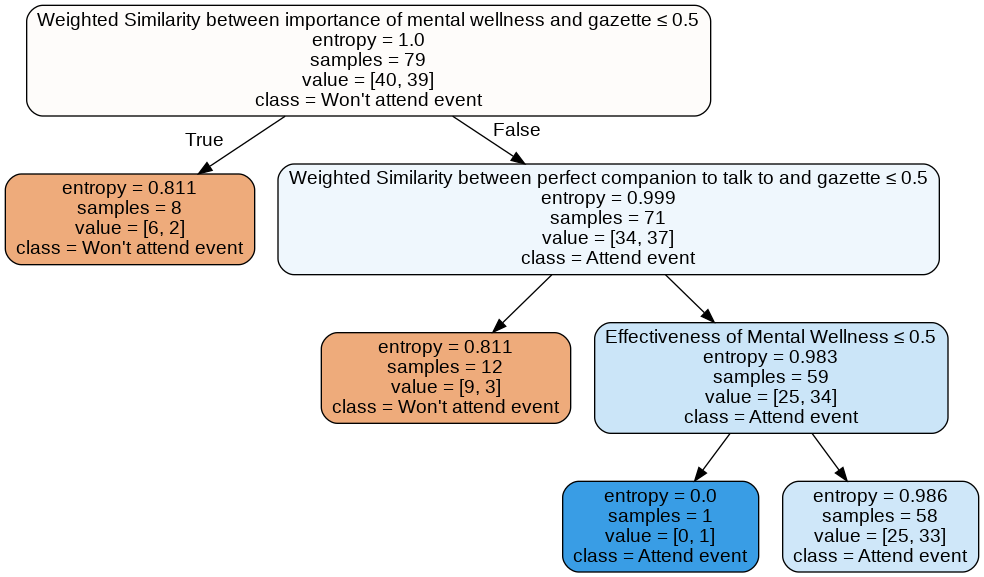

In [0]:
feature_cols = X_train.columns

dot_data = StringIO()
export_graphviz(dt, out_file = dot_data, 
                      feature_names = feature_cols,  
                     filled = True, rounded = True,  
                    special_characters = True,class_names=["Won't attend event",'Attend event'])



graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('Survey_Tree.png')
Image(graph.create_png())

#### Model Evaluation

In [0]:
try:
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    cnf_matrix = confusion_matrix(y_test, y_pred, labels = [1,0])
except:
    y_pred = dt.predict(X_test)[:len(y_pred)-1]
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    cnf_matrix = confusion_matrix(y_test, y_pred, labels = [1,0])

print("Accuracy Score for Decision Tree : {}".format(accuracy))
print("Recall Score for Decision Tree : {}".format(recall))
print("Precision Score for Decision Tree : {}".format(precision))
print("F1 Score for Decision Tree : {}".format(f1))
print("Confusion Matrix for Decision Tree:\n{}".format(cnf_matrix))

Accuracy Score for Decision Tree : 0.519
Recall Score for Decision Tree : 0.923
Precision Score for Decision Tree : 0.5
F1 Score for Decision Tree : 0.649
Confusion Matrix for Decision Tree:
[[12  1]
 [12  2]]


#### Feature Importance


Useless Columns:
['SMU undergraduate', 'Weighted Similarity between alternative task when stressed and gazette', 'Weighted Similarity between importance of talking to someone and gazette', 'Weighted Similarity between first task when stressed and gazette', 'Weighted Similarity between activity to relieve stress and gazette', 'Weighted Similarity between limitation of activity and gazette', 'Frequent participant for activity to maintain mental wellness']




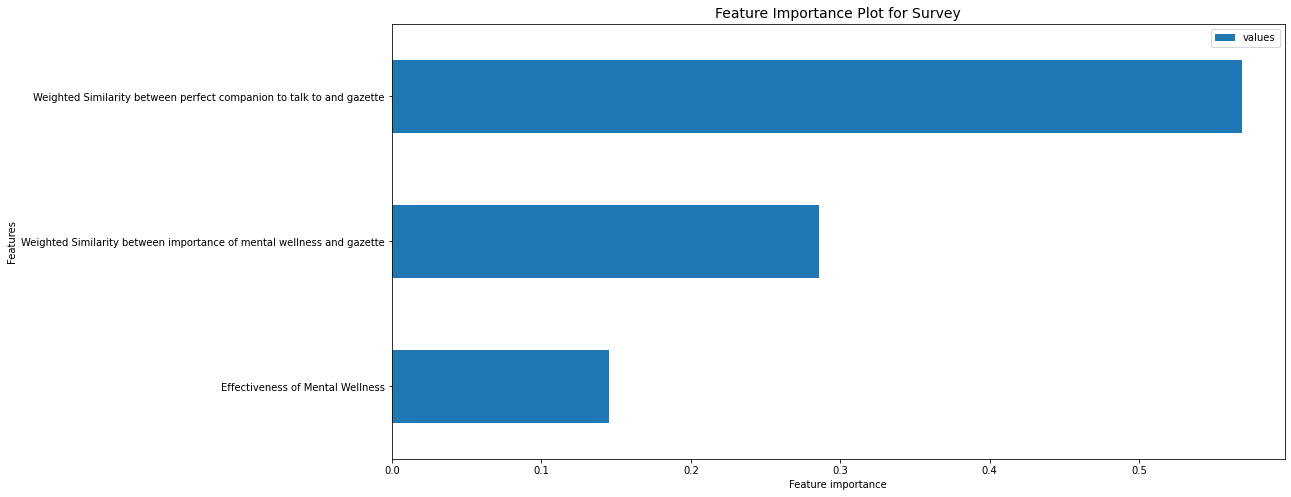

In [0]:
vi = dt.feature_importances_

n = len(feature_cols)
useless_column = []
labels = []
values = []

for i in range(0,n):
    # print(feature_cols[i] + '   :',vi[i].round(3))
    if vi[i] == 0:
        useless_column.append(feature_cols[i])
    else:
        labels.append(feature_cols[i])
        values.append(vi[i].round(3))

print('\nUseless Columns:\n{}\n\n'.format(useless_column))
feats_df = pd.DataFrame({'labels' : labels, 'values' : values})
# display(feats_df)
###
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

feats_df.sort_values("values").plot(kind='barh', x='labels', y='values', ax=ax)

# Additional parameters are given to you.
ax.set_title("Feature Importance Plot for Survey", fontsize=14)
ax.set_xlabel("Feature importance")
ax.set_ylabel("Features")
plt.show()

#### Calculating Odds

In [0]:
probability = dt.predict_proba(X_test)
not_coming = []
coming = []

features = list(feats_df['labels'])
for i in range(len(probability)):
    not_coming.append(probability[i][0])
    coming.append(probability[i][1])

merge_df = X_test[features]
merge_df['Not Coming %'] = not_coming
merge_df['Coming %'] = coming
merge_df['Odds of coming'] =  merge_df['Coming %']  / merge_df['Not Coming %']
merge_df['Prediction on Odds'] = "Coming"

for index,row in merge_df.iterrows():
    if row['Odds of coming'] < 1:
        merge_df.loc[index,"Prediction on Odds"] = "Not Coming"

merge_df

,Similarity between perfect companion to talk to and gazette,Similarity between importance of mental wellness and gazette,Effectiveness of Mental Wellness,Not Coming %,Coming %,Odds of coming,Prediction on Odds
0,1,1,1,0.431034,0.568966,1.320000,Coming
1,1,1,1,0.431034,0.568966,1.320000,Coming
2,1,1,1,0.431034,0.568966,1.320000,Coming
3,1,1,1,0.431034,0.568966,1.320000,Coming
4,1,1,1,0.431034,0.568966,1.320000,Coming
5,1,1,1,0.431034,0.568966,1.320000,Coming
6,1,1,1,0.431034,0.568966,1.320000,Coming
7,1,1,1,0.431034,0.568966,1.320000,Coming
8,1,1,1,0.431034,0.568966,1.320000,Coming
9,1,1,1,0.431034,0.568966,1.320000,Coming


#### Summary of Prediction

In [0]:
prediction_df = merge_df.groupby('Prediction on Odds').size().reset_index(name='count')
prediction_df

,Prediction on Odds,count
0,Coming,24
1,Not Coming,3
